# PART 1: Face recognition (face dataset)

### Fetch data

Downloading...
From: https://drive.google.com/uc?id=1oL6qLbl0VRv7Dox2x_UB18fKvdPweiJK
To: /content/face.mat
100% 1.21M/1.21M [00:00<00:00, 76.7MB/s]
SHAPES: train: (2576, 416), test: (2576, 104)
DEVICE: cuda



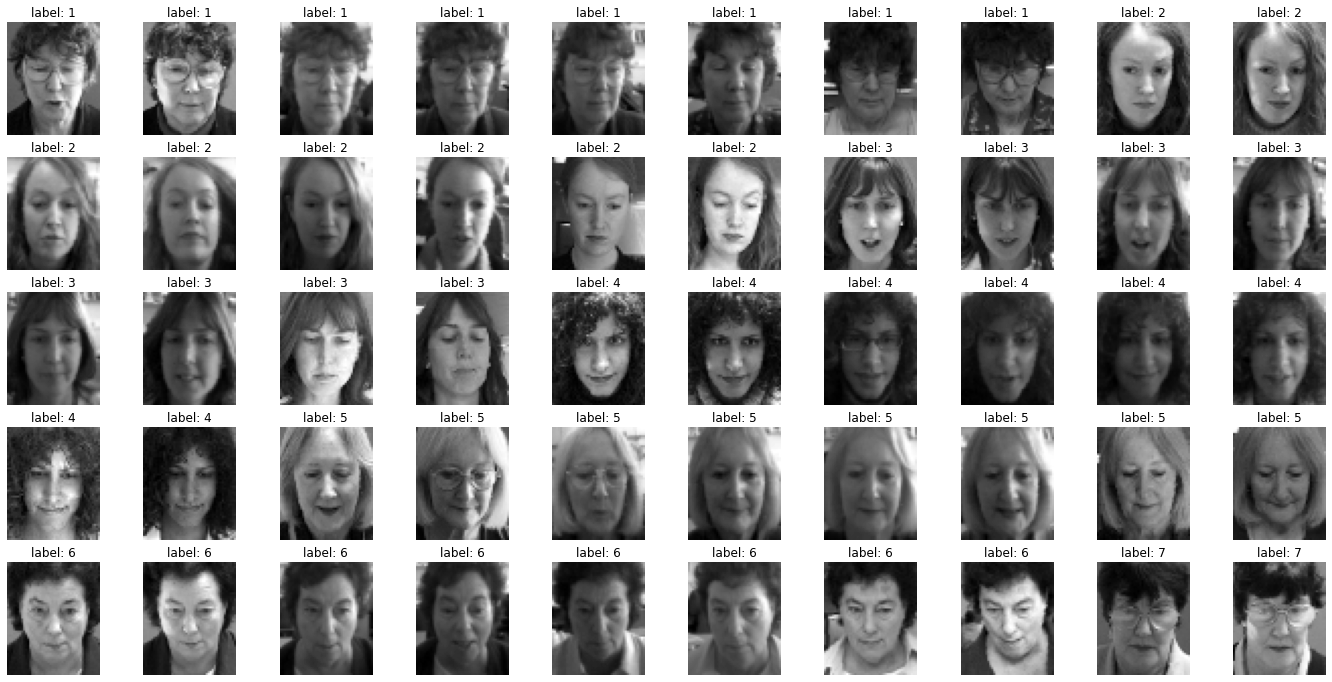

In [ ]:
import os
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
from tqdm import notebook
import math

num_classes = 52

# partition into train and test datasets
def split_data(faces):
  # first 8 faces for each class are used for training and 
  # the remaining 2 for testing
  idx_train = [i for j in range(num_classes) for i in range(j*10, j*10+8)]
  idx_test = [i for j in range(num_classes) for i in range(j*10 + 8, (j+1)*10)]
  labels_train = [j for j in range(1, num_classes + 1) for _ in range(8)]
  labels_test = [j for j in range(1, num_classes + 1) for _ in range(2)]
  return faces[:, idx_train], faces[:, idx_test], labels_train, labels_test

def load_data():
  if not os.path.exists('face.mat'):
    !pip install gdown
    !gdown --id 1oL6qLbl0VRv7Dox2x_UB18fKvdPweiJK
  face_mat = sio.loadmat('face.mat')
  faces = face_mat['X']
  return split_data(faces)
  
X_train, X_test, Y_train, Y_test = load_data()
print(f'SHAPES: train: {X_train.shape}, test: {X_test.shape}')

# visualize some faces
fig = plt.figure(figsize=(24, 12))
ax = []
for i, face in enumerate(X_train.T[:50]):
  ax.append(fig.add_subplot(5, 10, i+1))
  ax[-1].set_title(f"label: {Y_train[i]}")
  plt.imshow(np.reshape(face, (46,56)).T, cmap='gist_gray')
  plt.axis('off')

# work with pytorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'DEVICE: {device}\n')
torch.no_grad()
X_train = torch.from_numpy(X_train).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)

### Q1

#### Setup

In [ ]:
def eig_dec(S, show_time=True):
  t0 = time.time()
  eig_vals, eig_vecs = torch.linalg.eig(S)
  t = round(time.time() - t0, 4)
  if show_time:
    print(f"Eigen decomposition finished in: {t} secs")
  eig_vals, eig_vecs = eig_vals.real, eig_vecs.real
  idx = eig_vals.argsort(descending=True)
  eig_vals = eig_vals[idx].cpu()
  eig_vecs = eig_vecs[:,idx]
  return eig_vals, eig_vecs

def train_PCA(X, low_dim: bool):
  _, N = X.shape
  mean = X.mean(axis=1, keepdims=True)
  plt.imshow(np.reshape(mean.cpu().numpy(), (46,56)).T, cmap='gist_gray')
  plt.axis('off')
  plt.title('Mean face')
  A = X - mean
  S_ = ((A @ A.T) / N) # DxD covariance matrix
  S = ((A.T @ A) / N) if low_dim else S_
  eig_vals, eig_vecs = eig_dec(S)
  if low_dim:
    eig_vecs = torch.nn.functional.normalize(A @ eig_vecs, p=2.0, dim=0)
  return mean, S_, eig_vals, eig_vecs, A

def NN(v, X, Y):
  dist = torch.linalg.norm(X - v, dim=1, ord=None) # euclidean distance
  idx = dist.argsort(descending=False)
  return Y[idx[0]]

def test_PCA(eig_vecs, X_train, X_test, M: int, Y_train, confusion_mat: bool = False):
  assert M > 0 and M <= eig_vecs.shape[1]
  P = eig_vecs[:, :M] # projection matrix (D, M)
  assert  P.shape == (X_train.shape[0], M)
  XP_train = X_train.T @ P
  XP_test = X_test.T @ P
  correct = 0
  euc_error = 0.0 # euclidean -total- reconstruction error
  ang_error = 0.0 # angular -total- reconstruction error
  confusion_mat = torch.zeros((num_classes, num_classes), dtype=torch.uint8) if confusion_mat else None
  for i, vec in enumerate(XP_test):
    # classification accuracy
    y = Y_test[i]
    pred = NN(vec, XP_train, Y_train)
    if y == pred:
      correct += 1
    # confusion matrix (if required)
    if confusion_mat != None:
      confusion_mat[y-1, pred-1] += 1
    # reconstruction error
    x = X_test[:, i] # original face
    x_r = P @ vec # reconstructed face
    euc_error += torch.linalg.norm(x - x_r, dim=0, ord=None)
    cos_sim = torch.nn.functional.cosine_similarity(x, x_r, dim=0, eps=1e-08)
    ang_error += torch.acos(cos_sim) / math.pi
  if confusion_mat == None:
    return correct / X_test.shape[1], float(euc_error), float(ang_error)
  return correct / X_test.shape[1], float(euc_error), float(ang_error), confusion_mat

def test_PCA_all_M(eig_vecs, X_train, X_test, Y_train, max_M=None, tqdm_leave=True, print_best=True):
  accuracies = []
  euc_errors = []
  ang_errors = []
  best_acc = best_euc_err = best_ang_err = None
  _, dim_eig_vecs = eig_vecs.shape
  max_M = dim_eig_vecs if max_M == None else min(dim_eig_vecs, max_M)
  for M in notebook.tqdm(range(1, max_M + 1), leave=tqdm_leave):
    accuracy, euc_err, ang_err = test_PCA(eig_vecs, X_train, X_test, M, Y_train)
    accuracies.append(accuracy)
    euc_errors.append(euc_err)
    ang_errors.append(ang_err)
    if best_acc == None or accuracy > best_acc[0]:
      best_acc = (accuracy, M)
    if best_euc_err == None or euc_err < best_euc_err[0]:
      best_euc_err = (euc_err, M)
    if best_ang_err == None or ang_err < best_ang_err[0]:
      best_ang_err = (ang_err, M)
  if print_best:
    print(f"Best accuracy: {round(float(best_acc[0]), 4)}, components: {best_acc[1]}")
    print(f"Best euclidean reconstruction error: {round(float(best_euc_err[0]), 4)}, components: {best_euc_err[1]}")
    print(f"Best angular reconstruction error: {round(float(best_ang_err[0]), 4)}, components: {best_ang_err[1]}")
  return accuracies, euc_errors, ang_errors, best_acc[1]

def visualize_eig_faces(eig_faces):
  fig = plt.figure(figsize=(24, 12))
  ax = []
  for i, eig_face in enumerate(eig_faces):
    ax.append(fig.add_subplot(5, 10, i+1))
    ax[-1].set_title(f"eig face #{i}")
    plt.imshow(np.reshape(eig_face.cpu().numpy(), (46,56)).T, cmap='gist_gray')
    plt.axis('off')

def visualize_confusion_mat(eig_vecs, X_train, X_test, M, Y_train):
  def int_to_str(i: int):
    assert i >= 0 and i < 100
    if i < 10:
      return f' {i}'
    return str(i)

  conf_mat = test_PCA(eig_vecs, X_train, X_test, M, Y_train, True)[-1]
  s = '  ,' + ','.join([int_to_str(i) for i in range(1, num_classes + 1)])
  for i, v in enumerate(conf_mat):
    s += f'''\n{int_to_str(i+1)}, {','.join([int_to_str(int(j)) for j in v])}'''
  print(s)
  print('(Actual class (rows) vs predicted (cols))')

def visualize_results(results: list, tick_step: int, y_label: str, x_label: str ='num components'):
  fig, axs = plt.subplots(figsize=(25, 10))
  axs.plot(range(1, len(results) + 1), results)
  axs.set(xlabel=x_label, ylabel=y_label)
  axs.xaxis.set_ticks(range(0, len(results) + 1, tick_step))

#### PCA approach

Eigen decomposition finished in: 9.6887 secs


  0%|          | 0/2576 [00:00<?, ?it/s]

Best accuracy: 0.6731, components: 82
Best euclidean reconstruction error: 55916.4609, components: 431
Best angular reconstruction error: 9.0584, components: 431


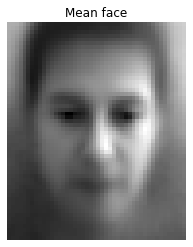

In [ ]:
mean, _, eig_vals, eig_vecs_PCA, A = train_PCA(X_train, False)
accuracies, euc_errors, ang_errors, M = test_PCA_all_M(eig_vecs_PCA, A, X_test - mean, Y_train)

lowest euc error components: 431, eig val: 0.024384327232837677
(nearby eig vals: [0.0282, 0.0278, 0.0265, 0.0253, 0.0244, 0.0238, 0.0236, 0.0226, 0.0226])


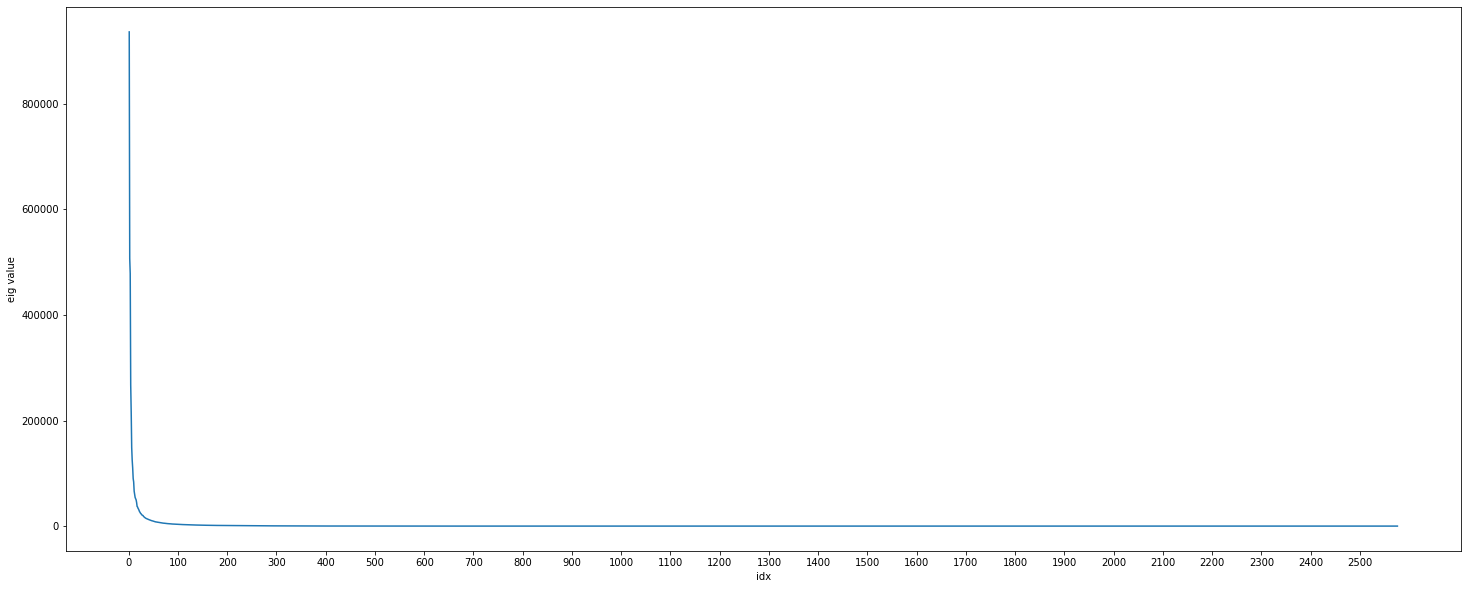

In [ ]:
visualize_results(eig_vals, 100, 'eig value', 'idx')
idx = euc_errors.index(min(euc_errors))
print(f'lowest euc error components: {idx+1}, eig val: {eig_vals[idx]}\n(nearby eig vals: {[round(float(ev), 4) for ev in eig_vals[idx-4:idx+5]]})')

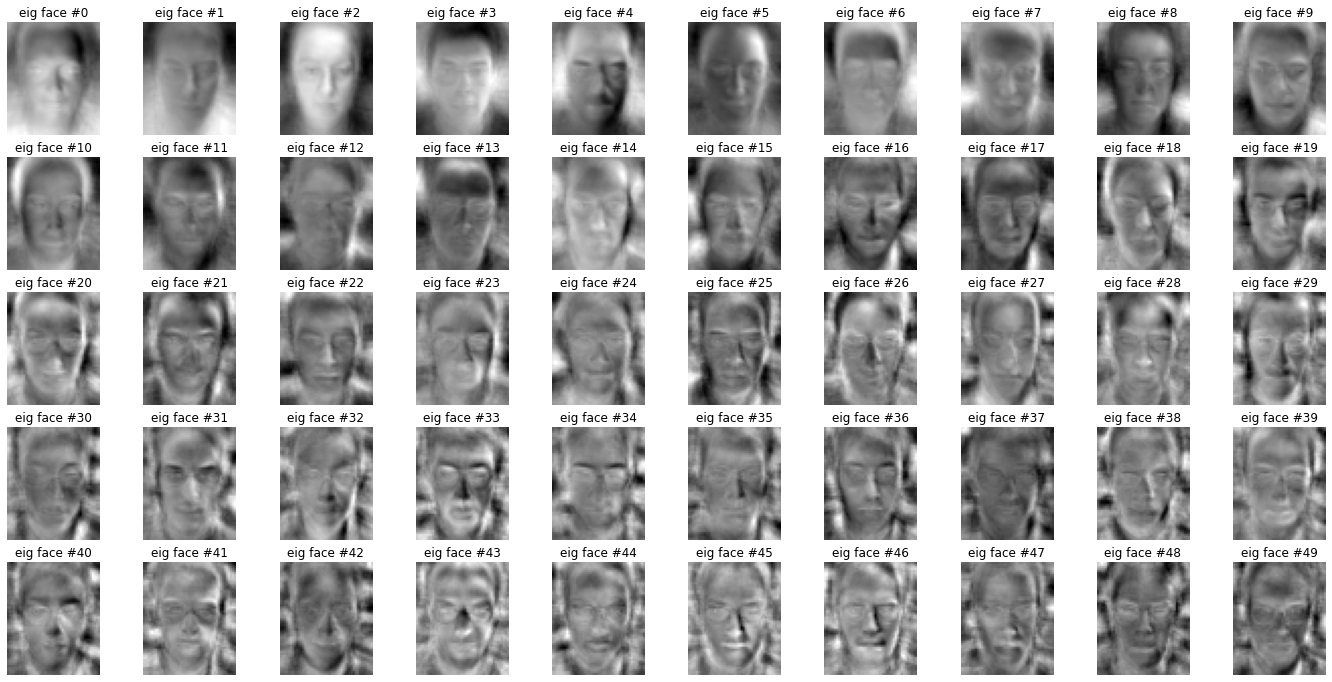

In [ ]:
visualize_eig_faces(eig_vecs_PCA.T[:50])

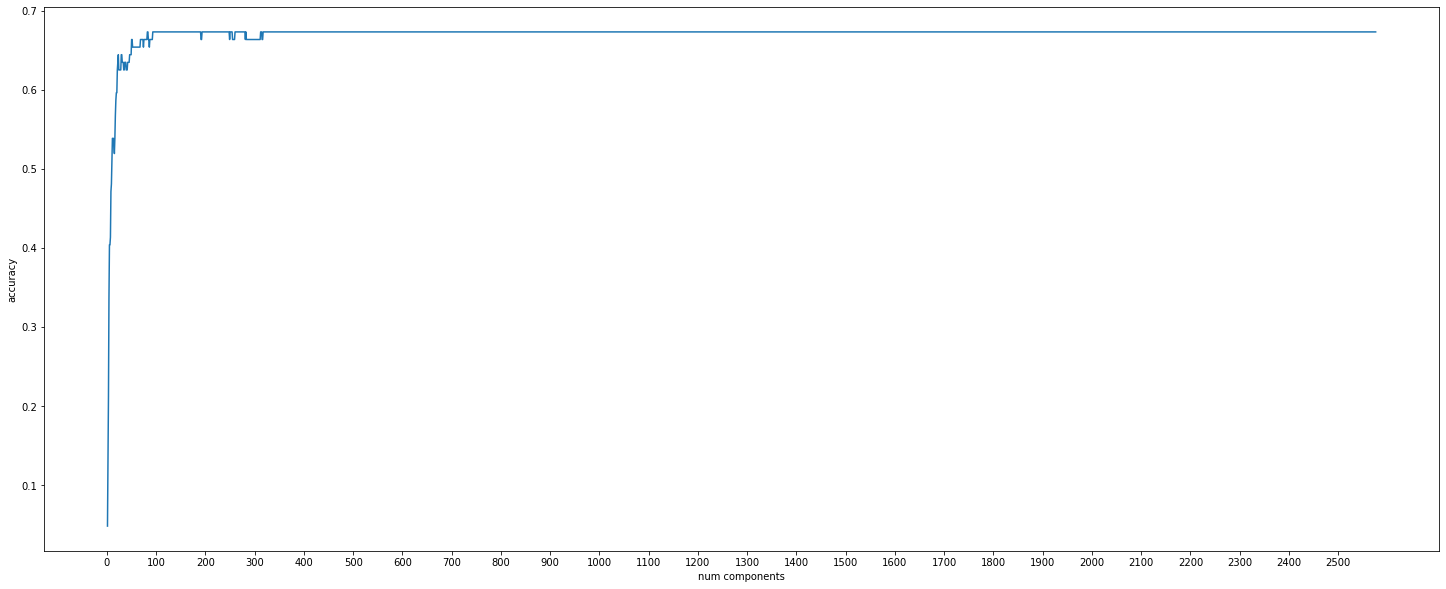

In [ ]:
visualize_results(accuracies, 100, 'accuracy')

In [ ]:
visualize_confusion_mat(eig_vecs_PCA, A, X_test - mean, M, Y_train)

  , 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52
 1,  0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
 2,  0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
 3,  0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
 4,  0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
 5,  0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
 6,  0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 

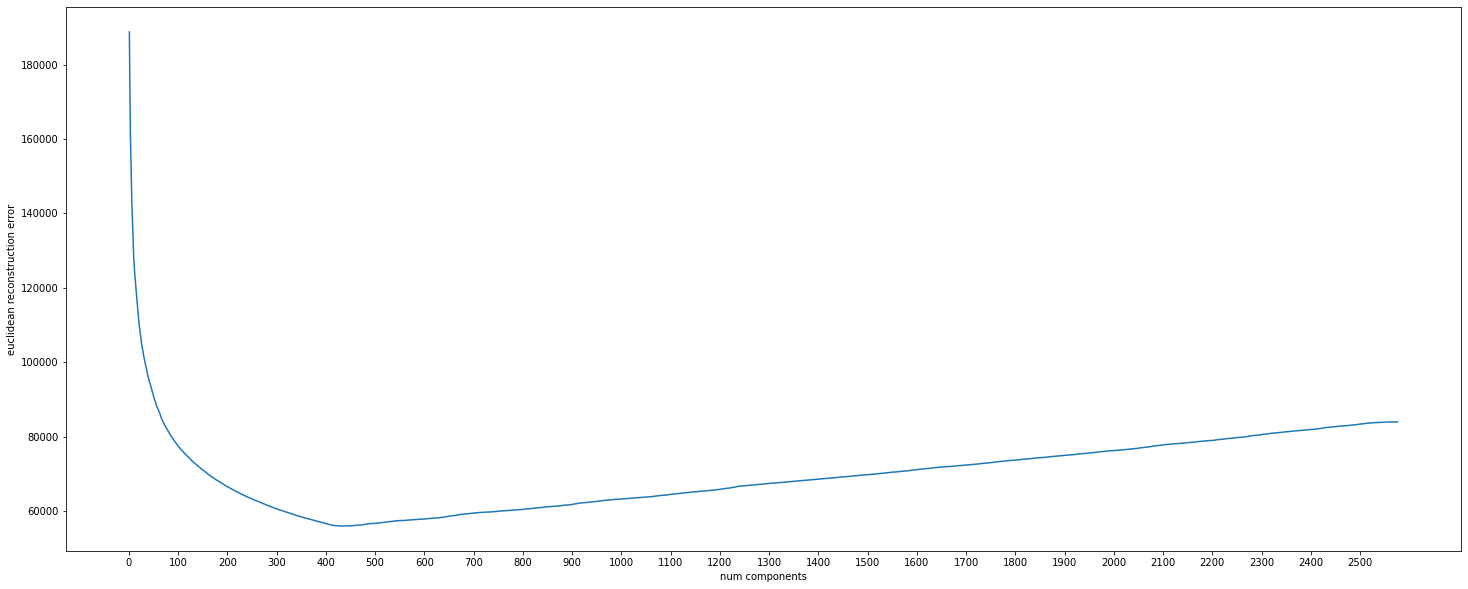

In [ ]:
visualize_results(euc_errors, 100, 'euclidean reconstruction error')

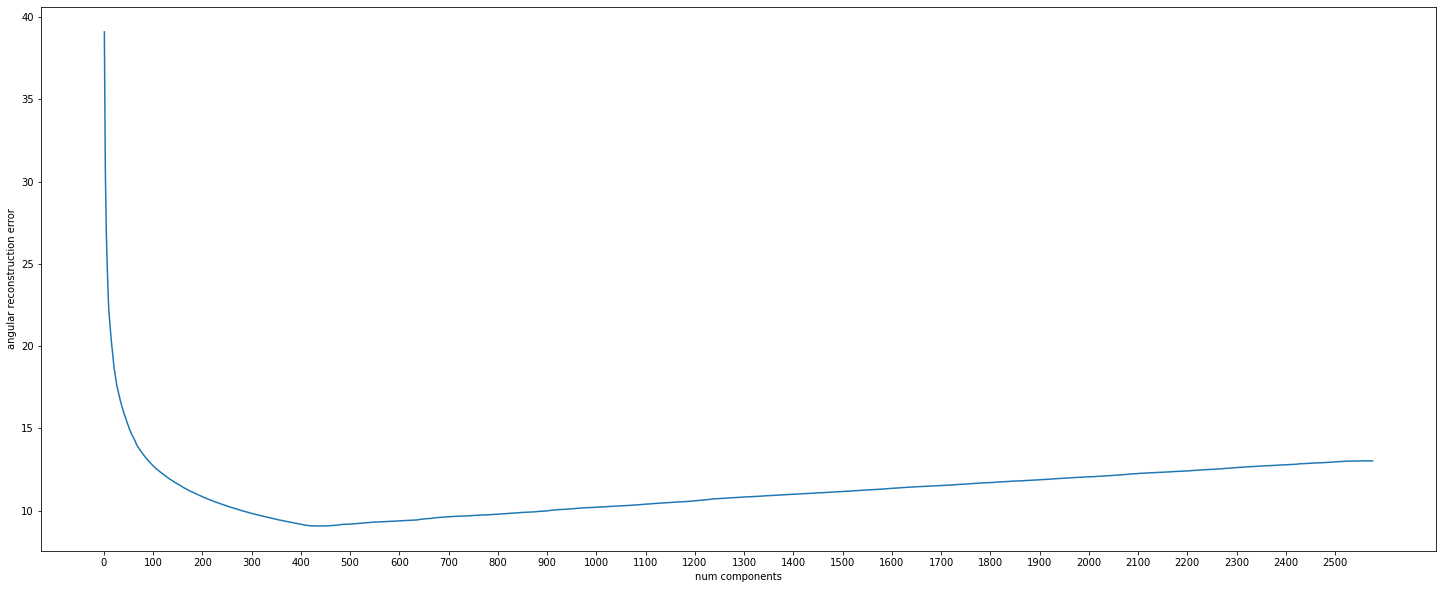

In [ ]:
visualize_results(ang_errors, 100, 'angular reconstruction error')

#### Low-dim PCA approach

Eigen decomposition finished in: 0.1375 secs


  0%|          | 0/416 [00:00<?, ?it/s]

Best accuracy: 0.6731, components: 82
Best euclidean reconstruction error: 56091.3477, components: 415
Best angular reconstruction error: 9.0874, components: 415


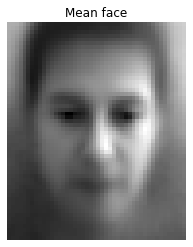

In [ ]:
mean, _, eig_vals, eig_vecs_ldPCA, A = train_PCA(X_train, True)
accuracies, euc_errors, ang_errors, M = test_PCA_all_M(eig_vecs_ldPCA, A, X_test - mean, Y_train)

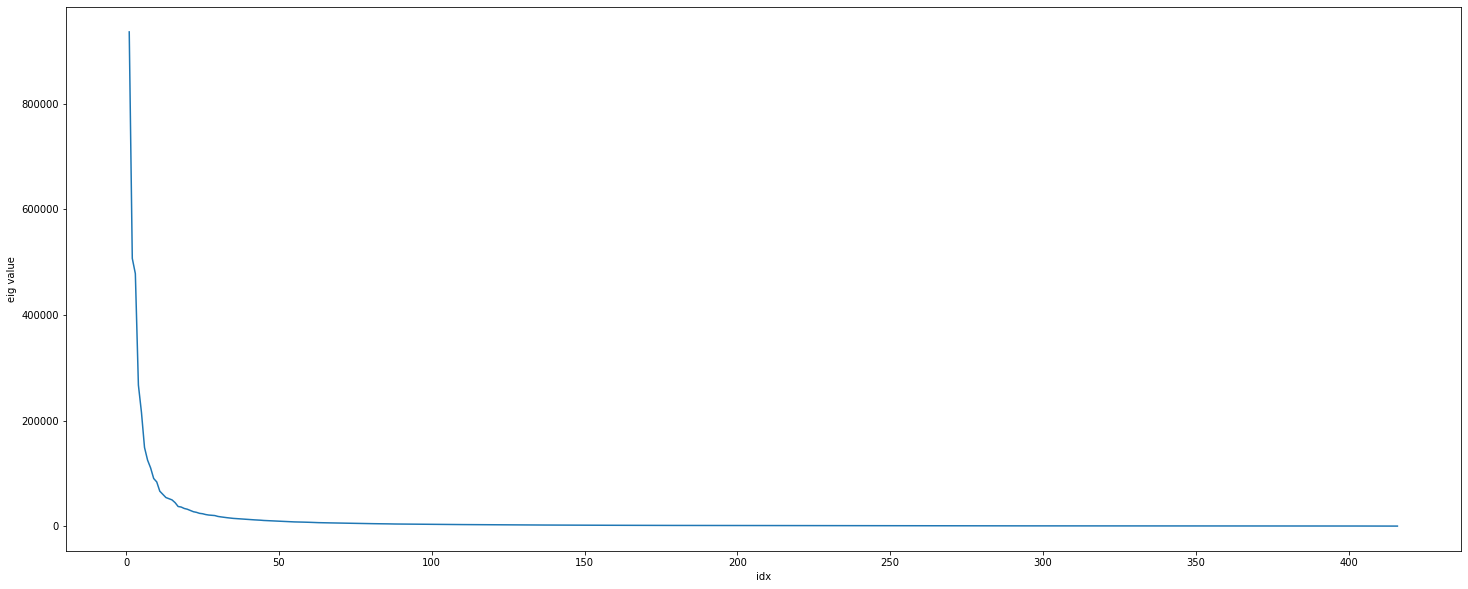

In [ ]:
visualize_results(eig_vals, 50, 'eig value', 'idx')

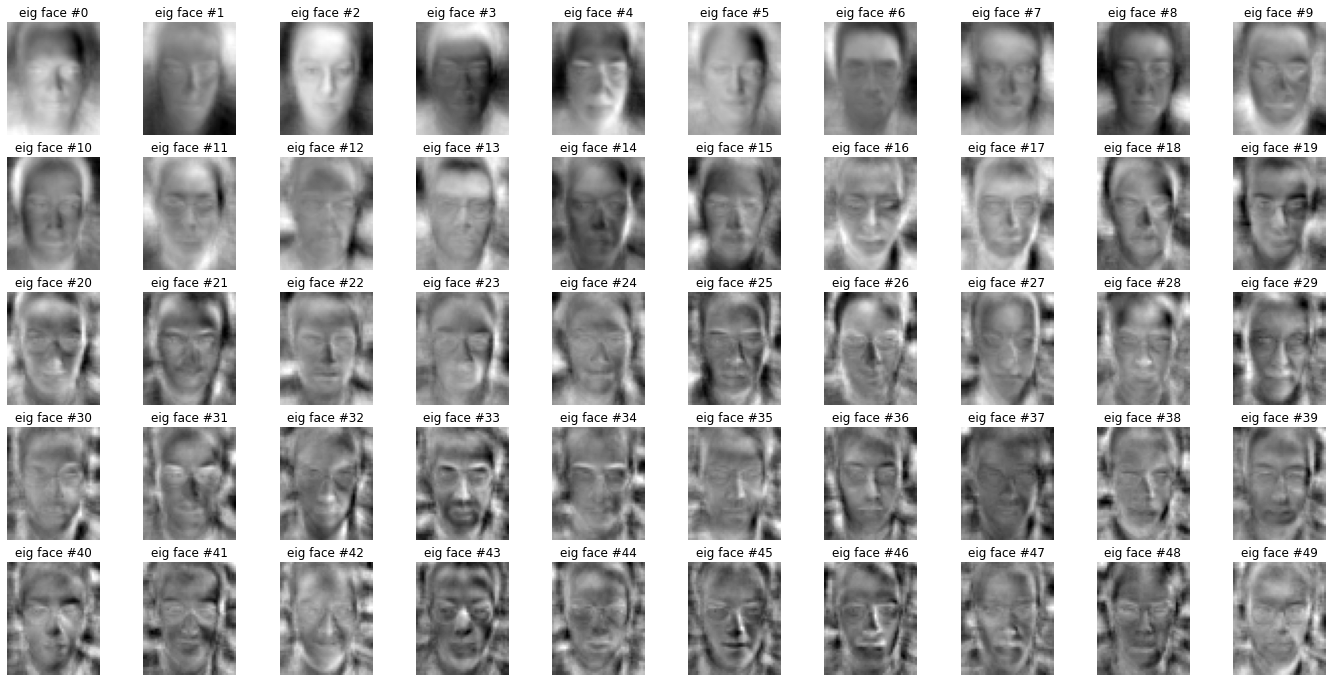

In [ ]:
visualize_eig_faces(eig_vecs_ldPCA.T[:50])

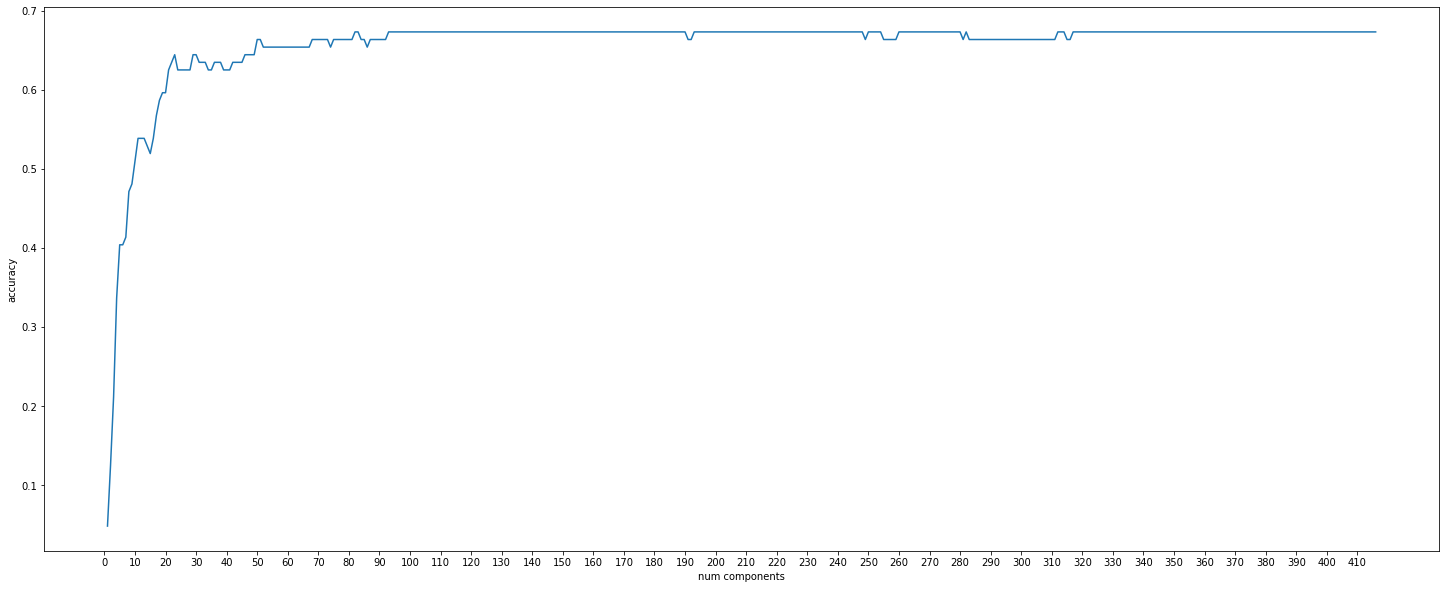

In [ ]:
visualize_results(accuracies, 10, 'accuracy')

In [ ]:
visualize_confusion_mat(eig_vecs_ldPCA, A, X_test - mean, M, Y_train)

  , 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52
 1,  0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
 2,  0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
 3,  0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
 4,  0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
 5,  0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
 6,  0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 

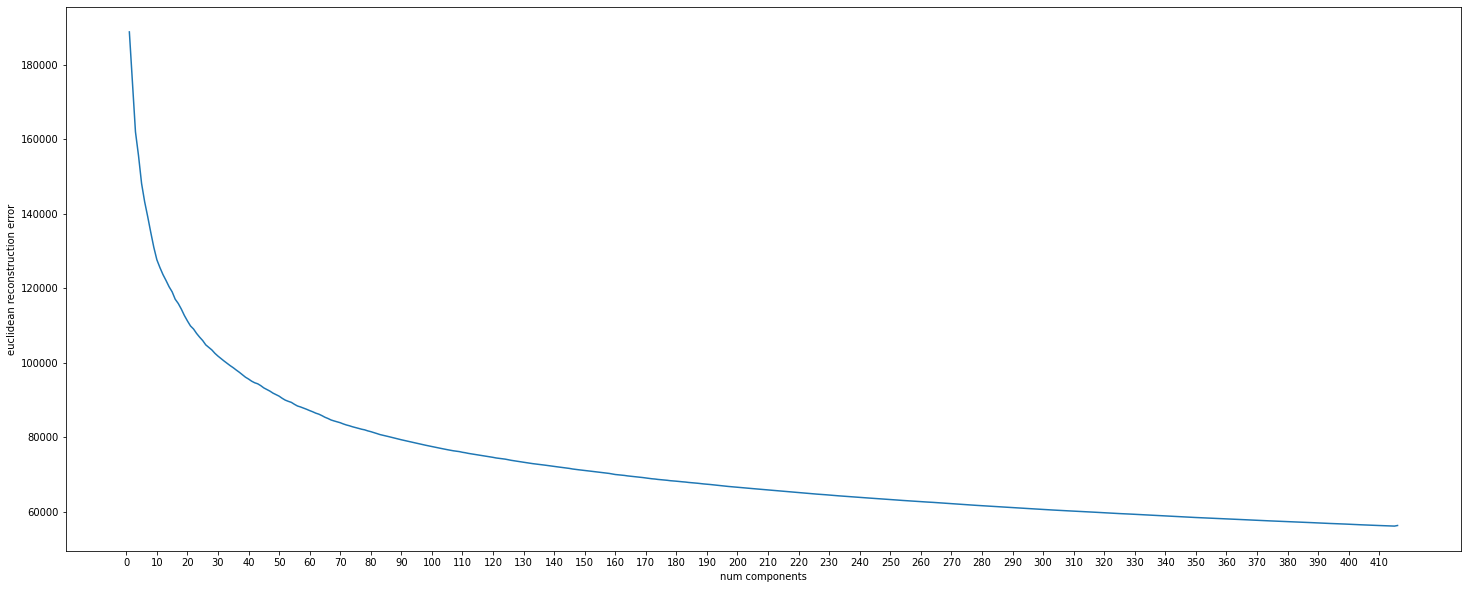

In [ ]:
visualize_results(euc_errors, 10, 'euclidean reconstruction error')

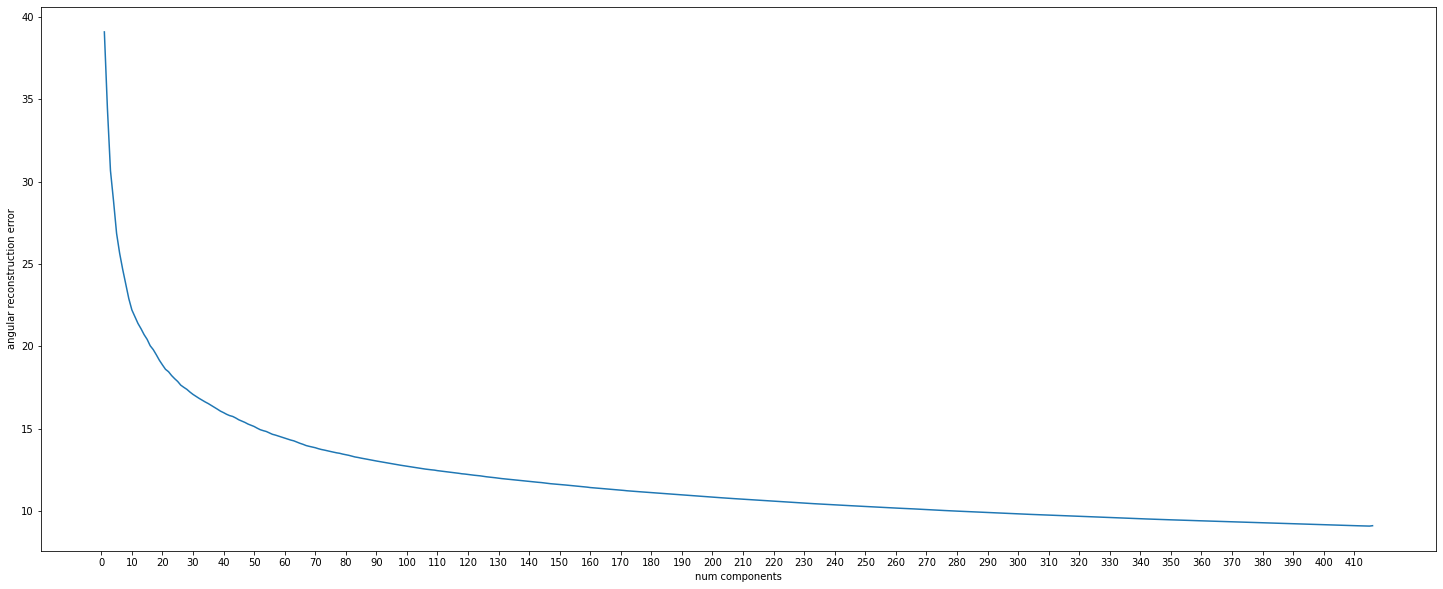

In [ ]:
visualize_results(ang_errors, 10, 'angular reconstruction error')

In [ ]:
# get the difference between both methods' eigenfaces
diff = torch.linalg.norm(eig_vecs_PCA[:, :eig_vecs_ldPCA.shape[1]] - eig_vecs_ldPCA, dim=0, ord=None)
print(f'max distance between equivalent eigenvectors: {round(float(max(diff)), 2)}, min: {round(float(min(diff)), 2)}')

max distance between equivalent eigenvectors: 2.0, min: 0.0


### Q2

#### Setup

In [ ]:
# divides the train dataset from Q1 into 4 subsets
def split_train(X):
  idx1 = [i for j in range(num_classes) for i in range(j*8, j*8+2)]
  idx2 = [i for j in range(num_classes) for i in range(j*8+2, j*8+4)]
  idx3 = [i for j in range(num_classes) for i in range(j*8+4, j*8+6)]
  idx4 = [i for j in range(num_classes) for i in range(j*8+6, j*8+8)]
  Y = [j for j in range(1, num_classes + 1) for _ in range(2)]
  return X[:, idx1], X[:, idx2], X[:, idx3], X[:, idx4], Y

# generates the sufficient spanning set matrix of X and removes its zero vectors
def h(X):
  Q, _ = torch.linalg.qr(X)
  non_zero = torch.linalg.norm(Q, dim=0, ord=None).isclose(torch.ones(Q.shape[1], device=device))
  return Q[:, non_zero]

def increment_PCA(u1, S1, N1: int, P1, u2, S2, N2: int, P2):
  N3 = N1 + N2
  u3 = (N1 * u1 + N2 * u2) / N3
  plt.imshow(np.reshape(u3.cpu().numpy(), (46,56)).T, cmap='gist_gray')
  plt.axis('off')
  plt.title('(Incremented) Mean face')
  u12 = u1 - u2
  S3 = (N1 / N3) * S1 + (N2 / N3) * S2 + ((N1 * N2 / N3) * u12) @ u12.T
  phi = h(torch.cat((P1, P2, u12), 1))
  eig_vals, R = eig_dec(phi.T @ S3 @ phi)
  P3 = phi @ R
  return u3, S3, eig_vals, P3, N3

X1_train, X2_train, X3_train, X4_train, Yn_train = split_train(X_train)

#### Incremental PCA approach (1 subset)

Eigen decomposition finished in: 0.0049 secs


  0%|          | 0/104 [00:00<?, ?it/s]

Best accuracy: 0.2788, components: 21
Best euclidean reconstruction error: 108474.0703, components: 103
Best angular reconstruction error: 16.8285, components: 103


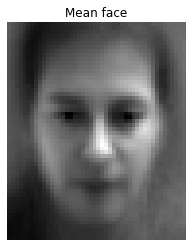

In [ ]:
mean1, S1, eig_vals_1, eig_vecs_1, A_1 = train_PCA(X1_train, True)
accuracies, euc_errors, ang_errors, M = test_PCA_all_M(eig_vecs_1, A_1, X_test - mean1, Yn_train)

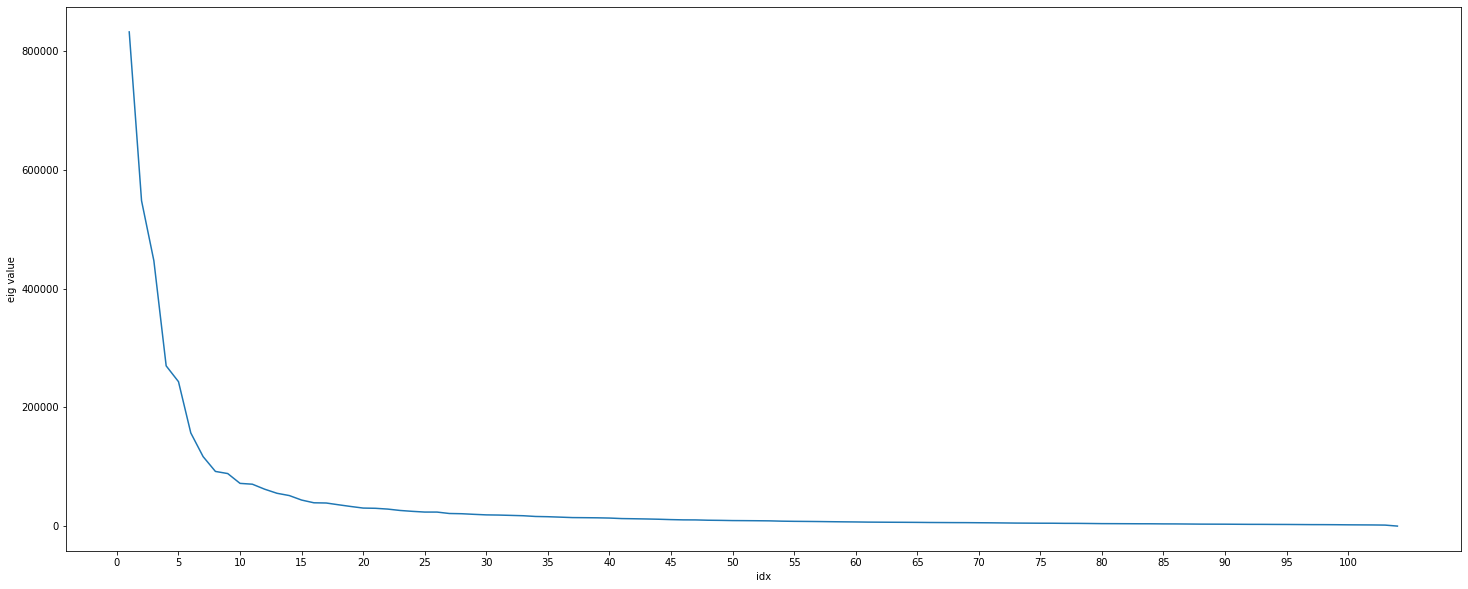

In [ ]:
visualize_results(eig_vals_1, 5, 'eig value', 'idx')

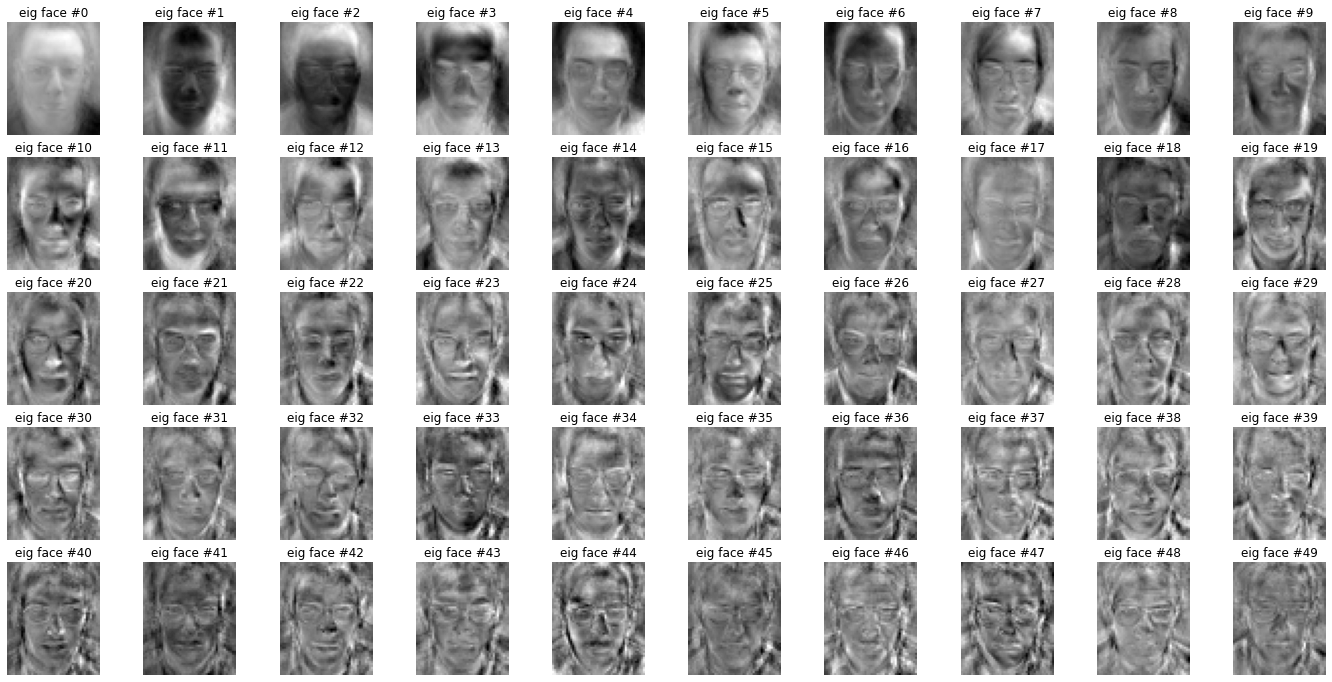

In [ ]:
visualize_eig_faces(eig_vecs_1.T[:50])

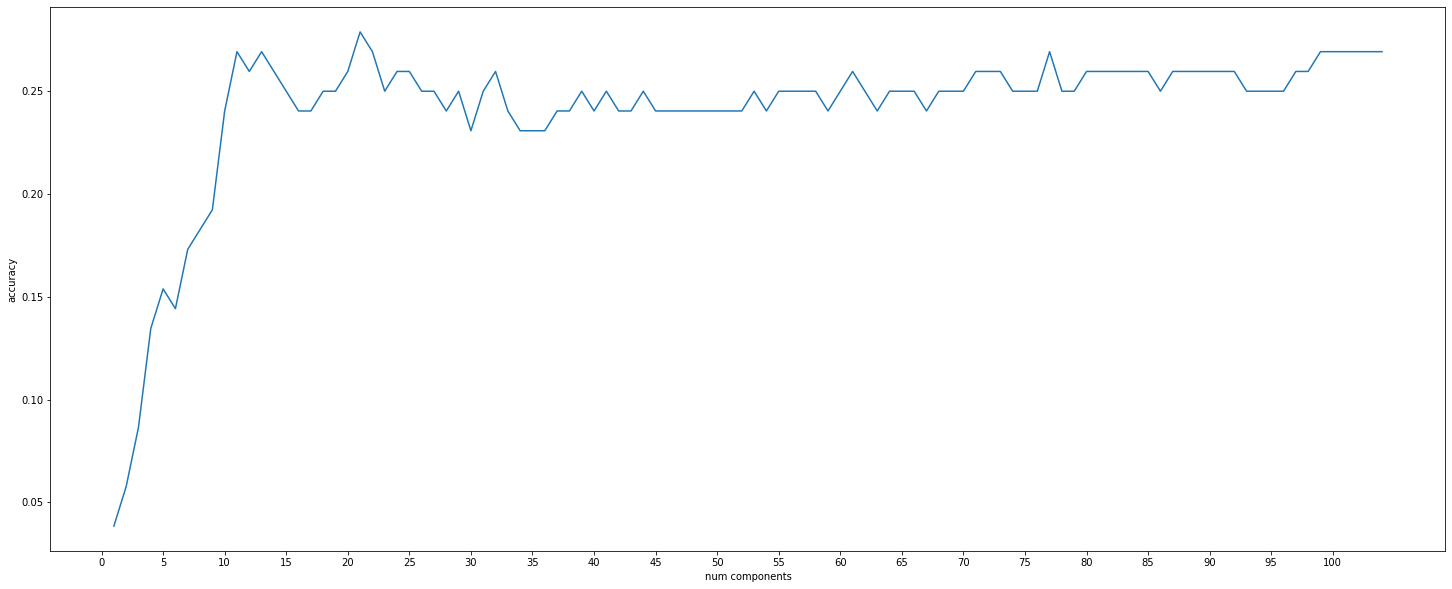

In [ ]:
visualize_results(accuracies, 5, 'accuracy')

In [ ]:
visualize_confusion_mat(eig_vecs_1, A_1, X_test - mean1, M, Yn_train)

  , 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52
 1,  0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
 2,  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0
 3,  0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
 4,  0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
 5,  0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
 6,  0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 

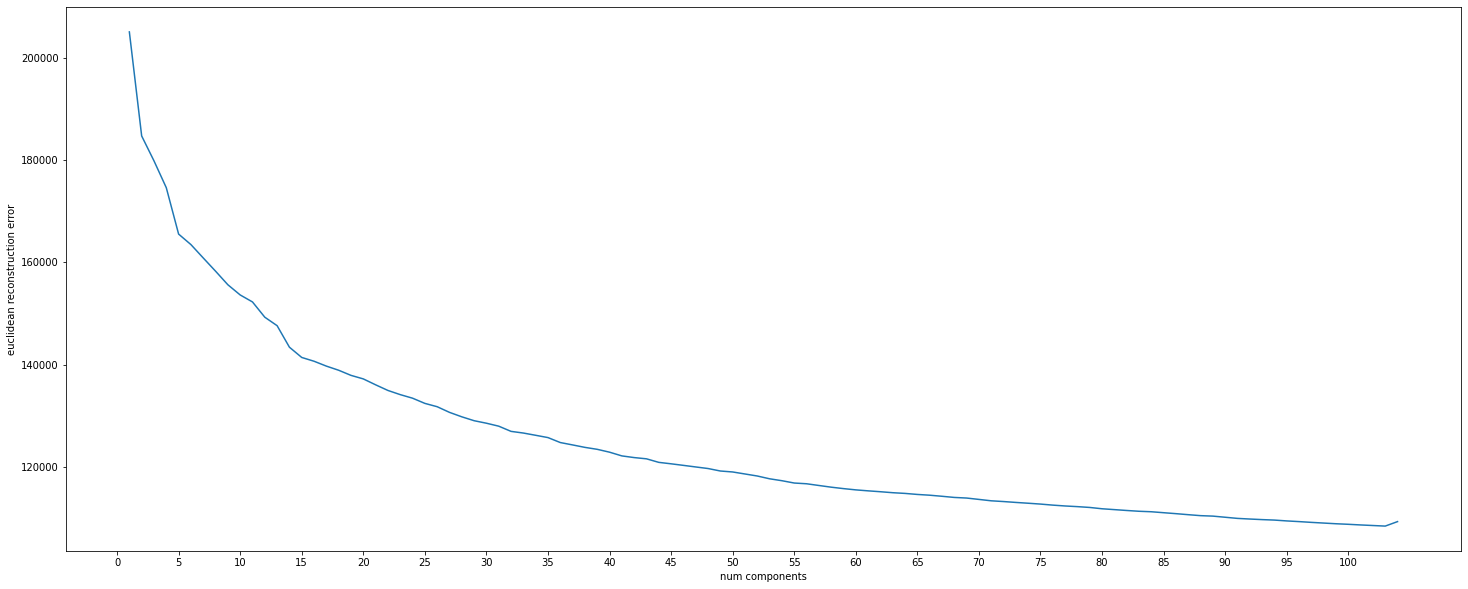

In [ ]:
visualize_results(euc_errors, 5, 'euclidean reconstruction error')

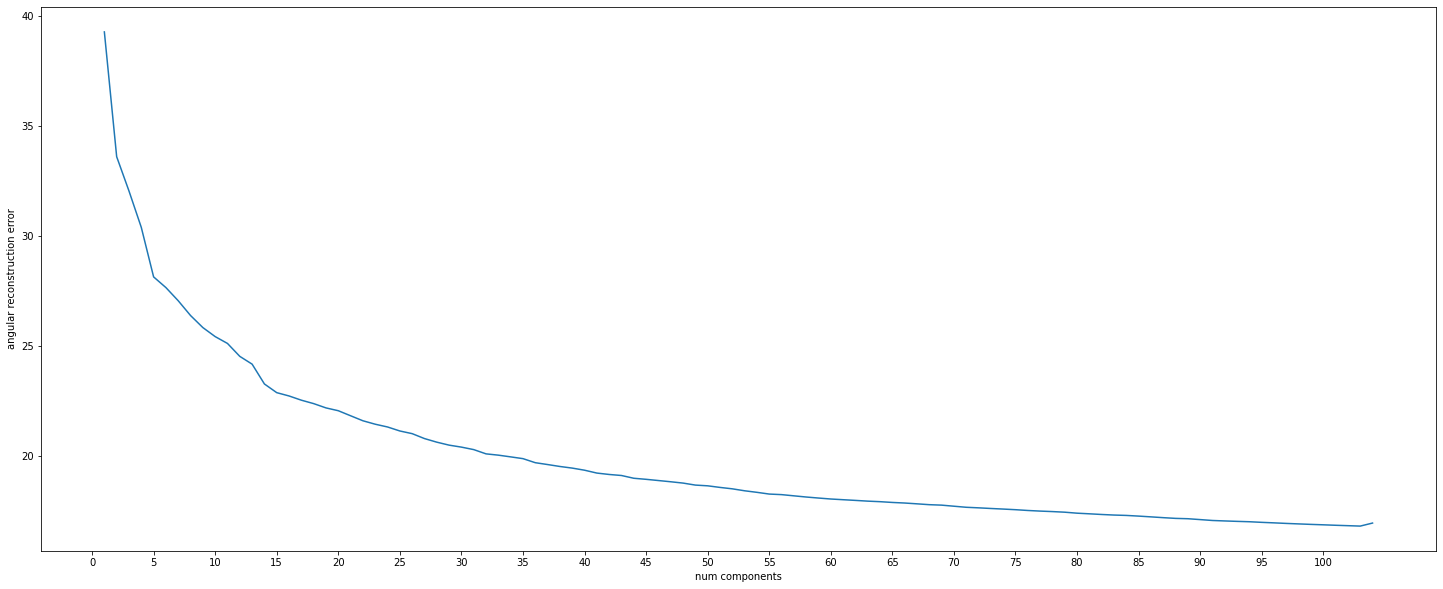

In [ ]:
visualize_results(ang_errors, 5, 'angular reconstruction error')

#### Incremental PCA approach (2 subsets)

Eigen decomposition finished in: 0.0048 secs


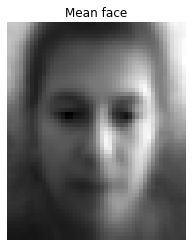

In [ ]:
# train PCA on the 2nd subset
mean2, S2, eig_vals_2, eig_vecs_2, _ = train_PCA(X2_train, True)

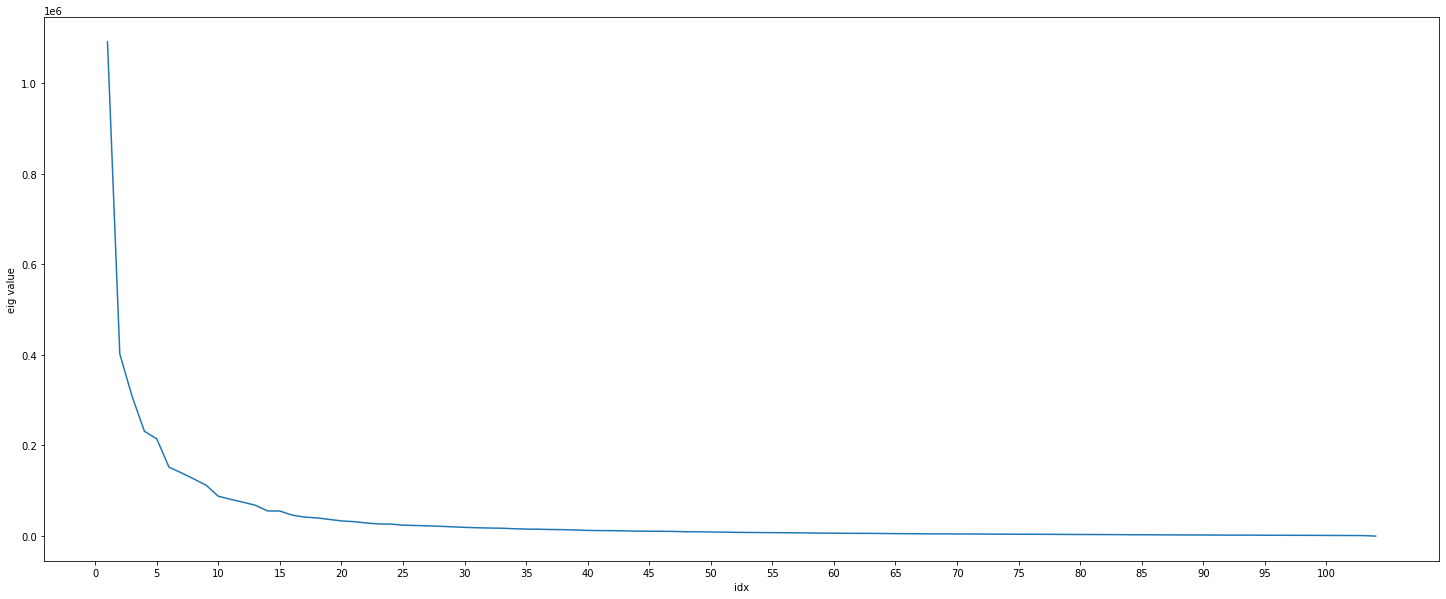

In [ ]:
visualize_results(eig_vals_2, 5, 'eig value', 'idx')

Eigen decomposition finished in: 0.0197 secs


  0%|          | 0/209 [00:00<?, ?it/s]

Best accuracy: 0.3173, components: 26
Best euclidean reconstruction error: 79945.4375, components: 208
Best angular reconstruction error: 12.6256, components: 208


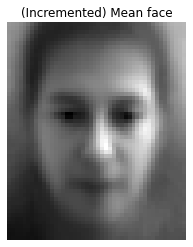

In [ ]:
N1 = X1_train.shape[1]
# get the incremented model
N2 = X2_train.shape[1]
mean2, S2, eig_vals_2, eig_vecs_2, N2 = increment_PCA(mean1, S1, N1, eig_vecs_1, mean2, S2, N2, eig_vecs_2)
X12_train = torch.cat((X1_train, X2_train), 1)
accuracies, euc_errors, ang_errors, M = test_PCA_all_M(eig_vecs_2, X12_train - mean2, X_test - mean2, 2 * Yn_train)

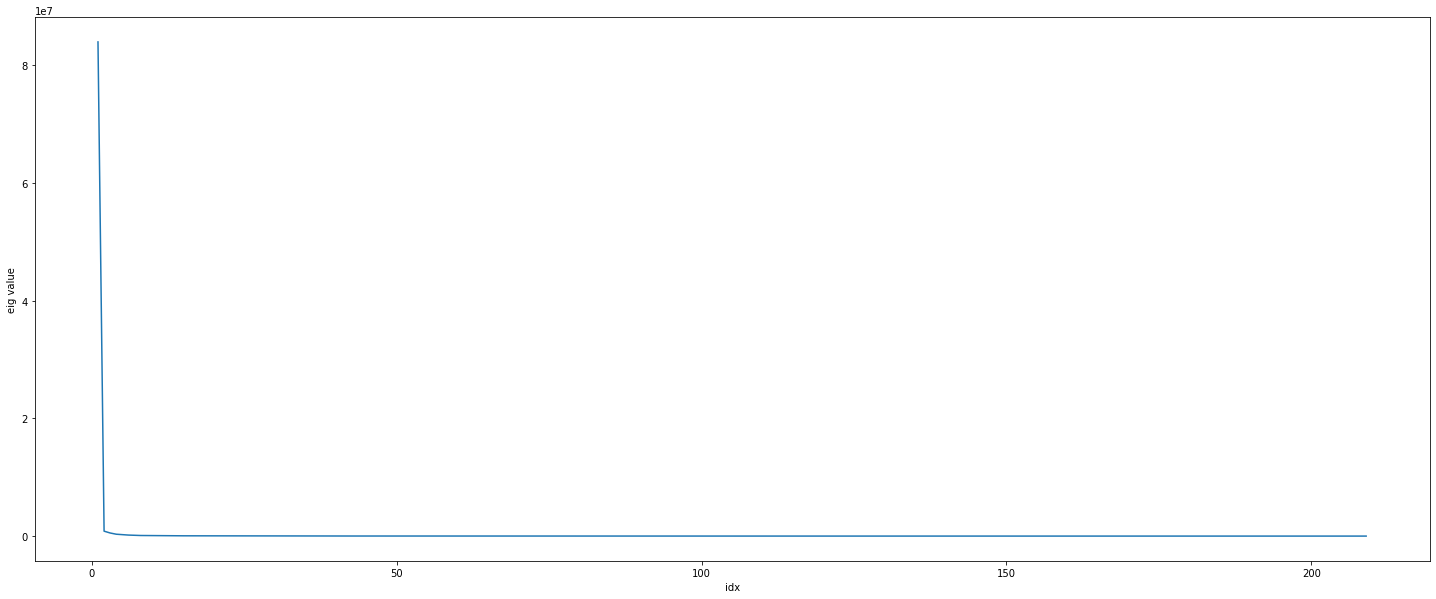

In [ ]:
visualize_results(eig_vals_2, 50, 'eig value', 'idx')

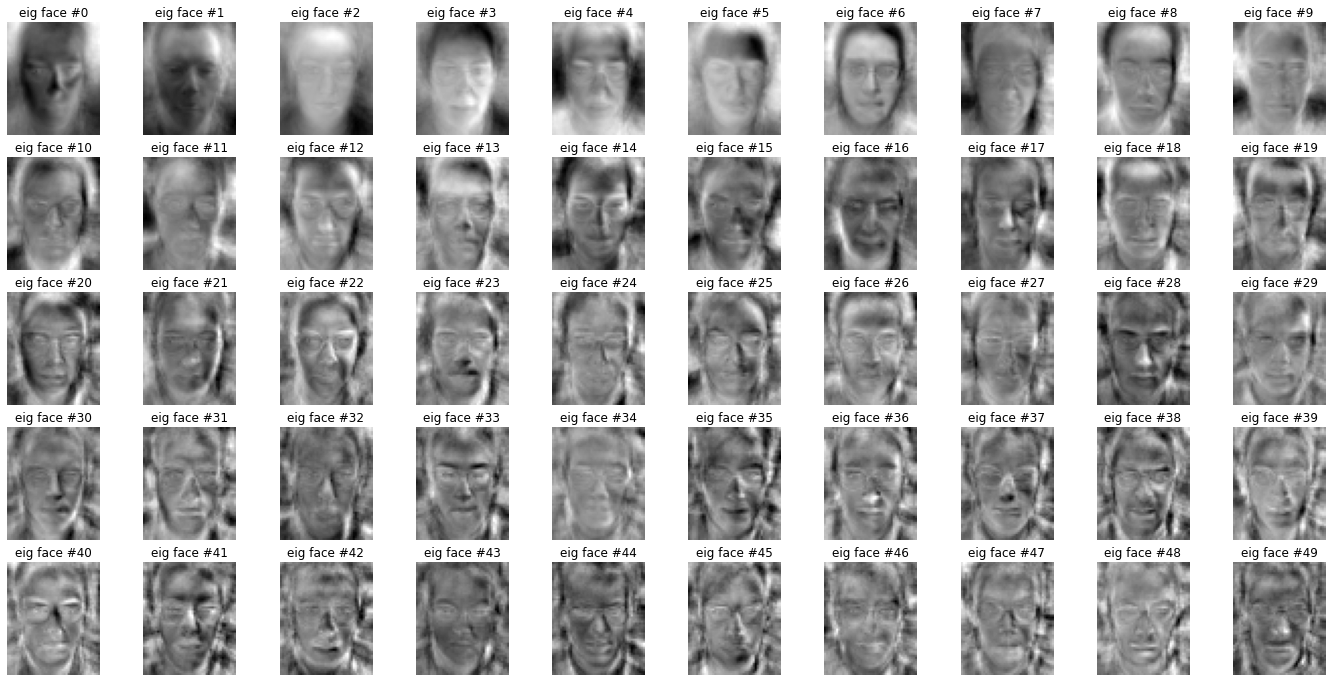

In [ ]:
visualize_eig_faces(eig_vecs_2.T[:50])

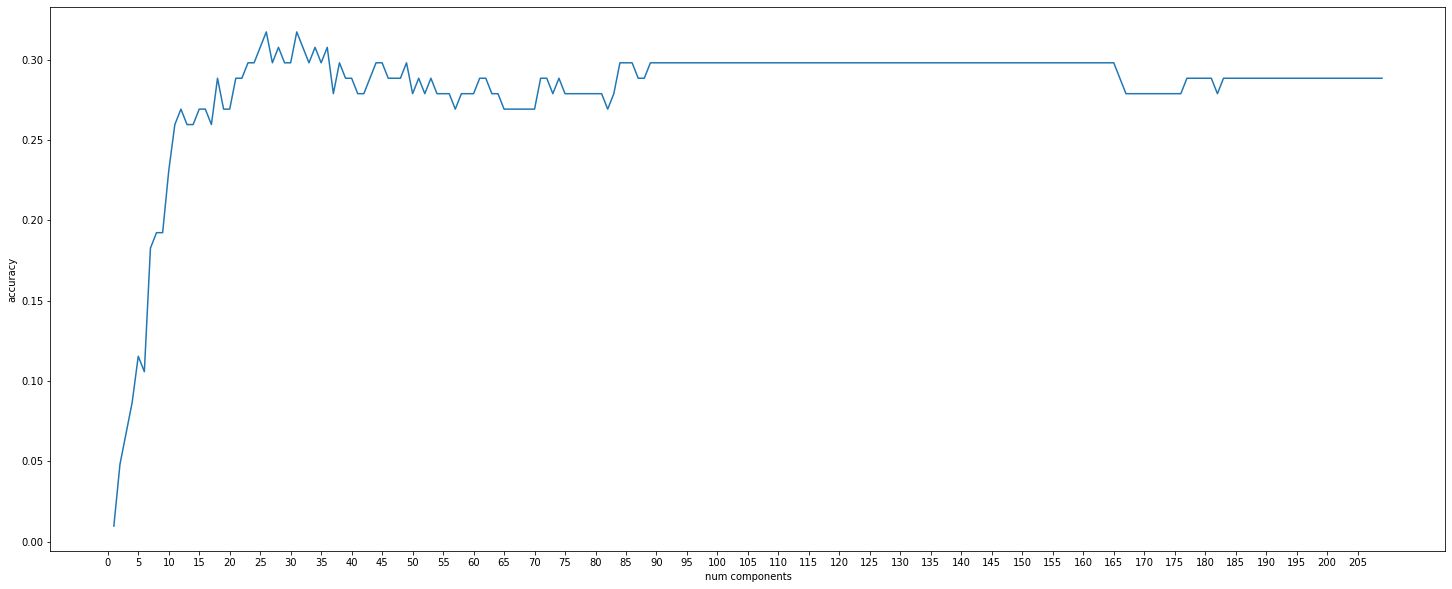

In [ ]:
visualize_results(accuracies, 5, 'accuracy')

In [ ]:
visualize_confusion_mat(eig_vecs_2, X12_train - mean2, X_test - mean2, M, 2 * Yn_train)

  , 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52
 1,  0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
 2,  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0
 3,  0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
 4,  0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
 5,  0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
 6,  0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 

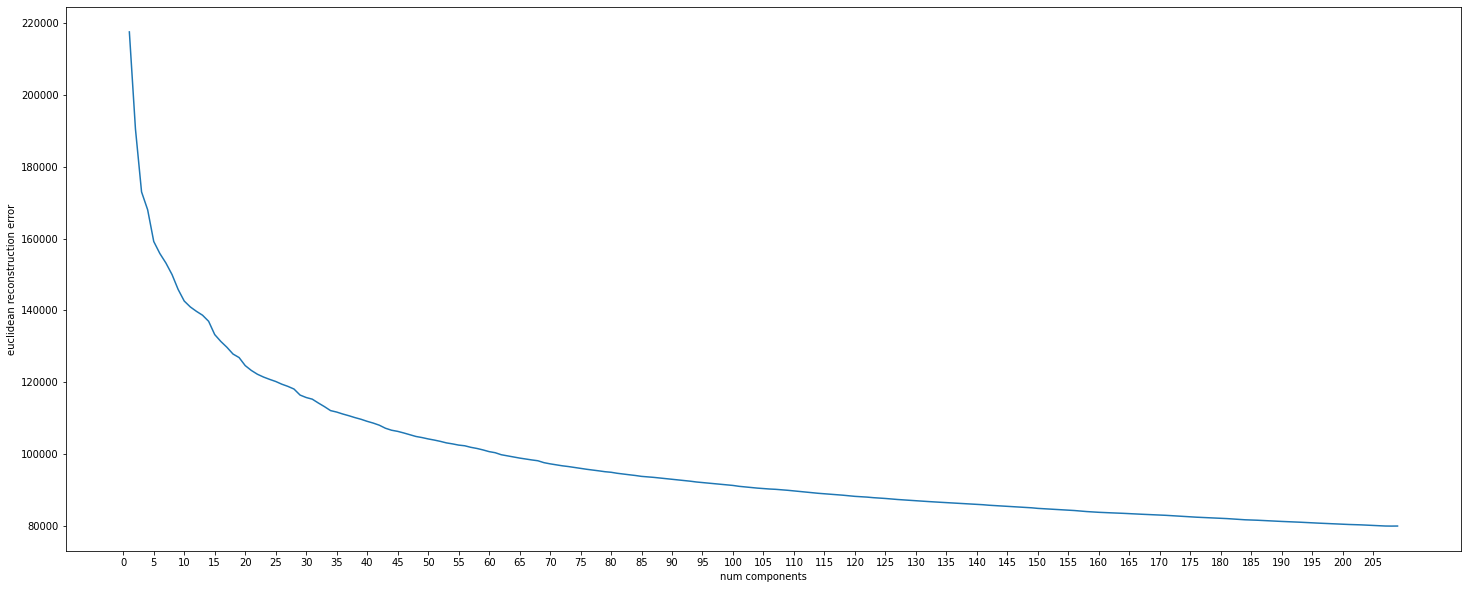

In [ ]:
visualize_results(euc_errors, 5, 'euclidean reconstruction error')

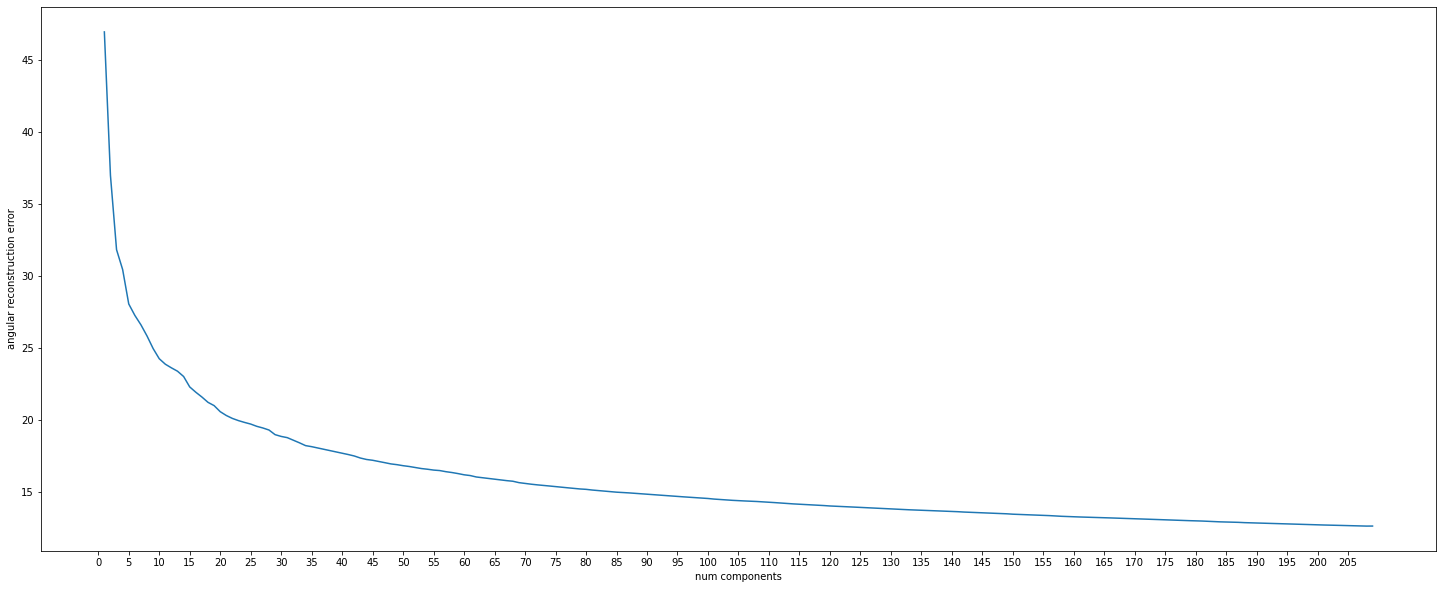

In [ ]:
visualize_results(ang_errors, 5, 'angular reconstruction error')

#### Incremental PCA approach (3 subsets)

Eigen decomposition finished in: 0.0052 secs


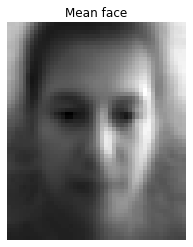

In [ ]:
# train PCA on the 3rd subset
mean3, S3, eig_vals_3, eig_vecs_3, _ = train_PCA(X3_train, True)

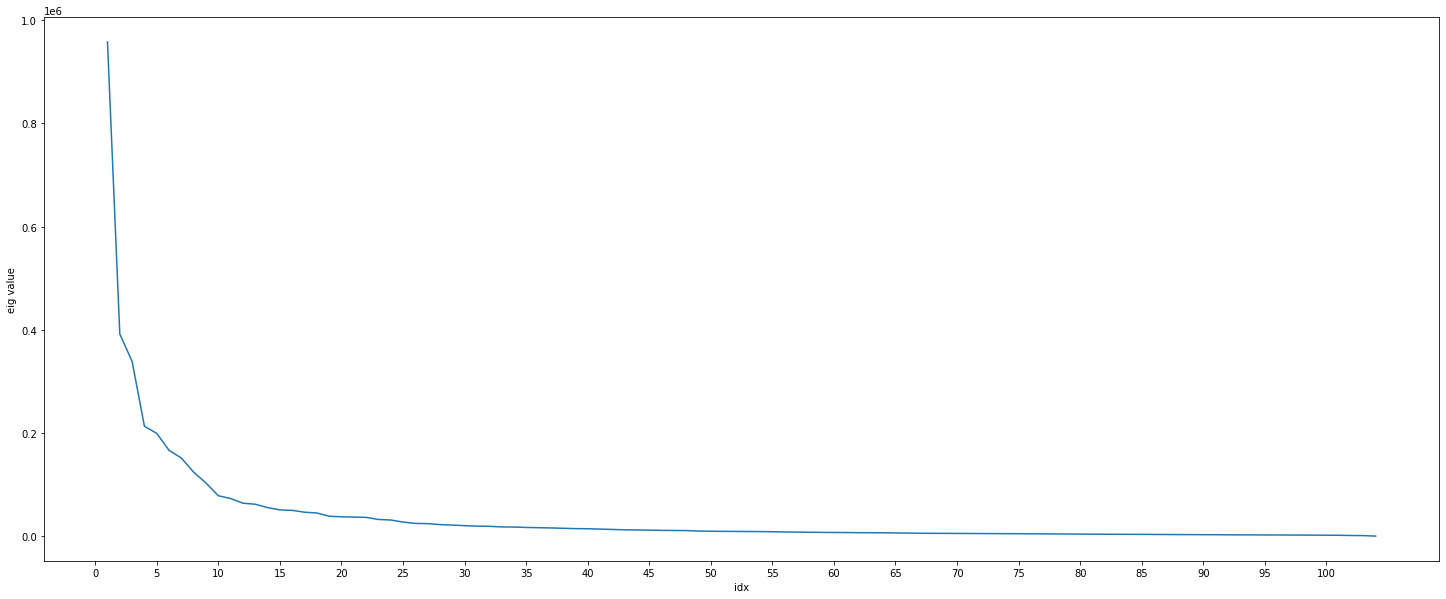

In [ ]:
visualize_results(eig_vals_3, 5, 'eig value', 'idx')

Eigen decomposition finished in: 0.0538 secs


  0%|          | 0/314 [00:00<?, ?it/s]

Best accuracy: 0.3654, components: 52
Best euclidean reconstruction error: 67411.4141, components: 312
Best angular reconstruction error: 10.4829, components: 312


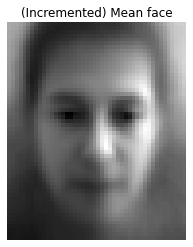

In [ ]:
# get the incremented model
N3 = X3_train.shape[1]
mean3, S3, eig_vals_3, eig_vecs_3, N3 = increment_PCA(mean2, S2, N2, eig_vecs_2, mean3, S3, N3, eig_vecs_3)
X123_train = torch.cat((X12_train, X3_train), 1)
accuracies, euc_errors, ang_errors, M = test_PCA_all_M(eig_vecs_3, X123_train - mean3, X_test - mean3, 3 * Yn_train)

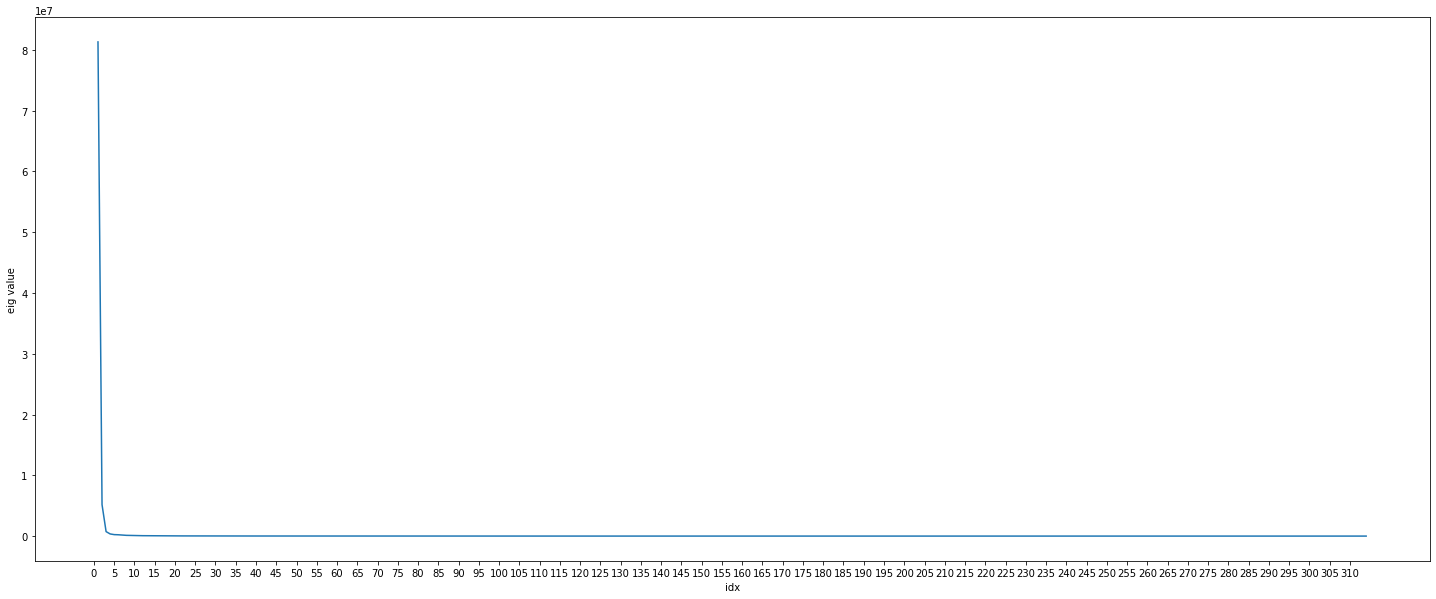

In [ ]:
visualize_results(eig_vals_3, 5, 'eig value', 'idx')

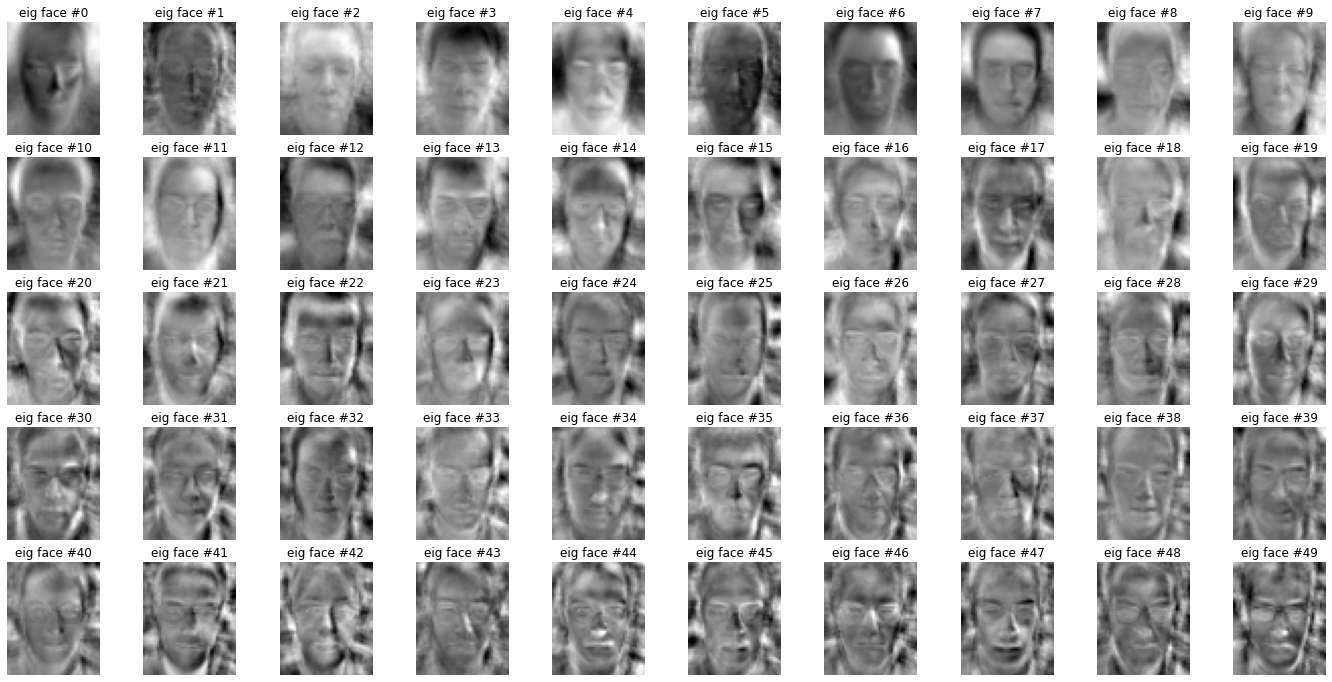

In [ ]:
visualize_eig_faces(eig_vecs_3.T[:50])

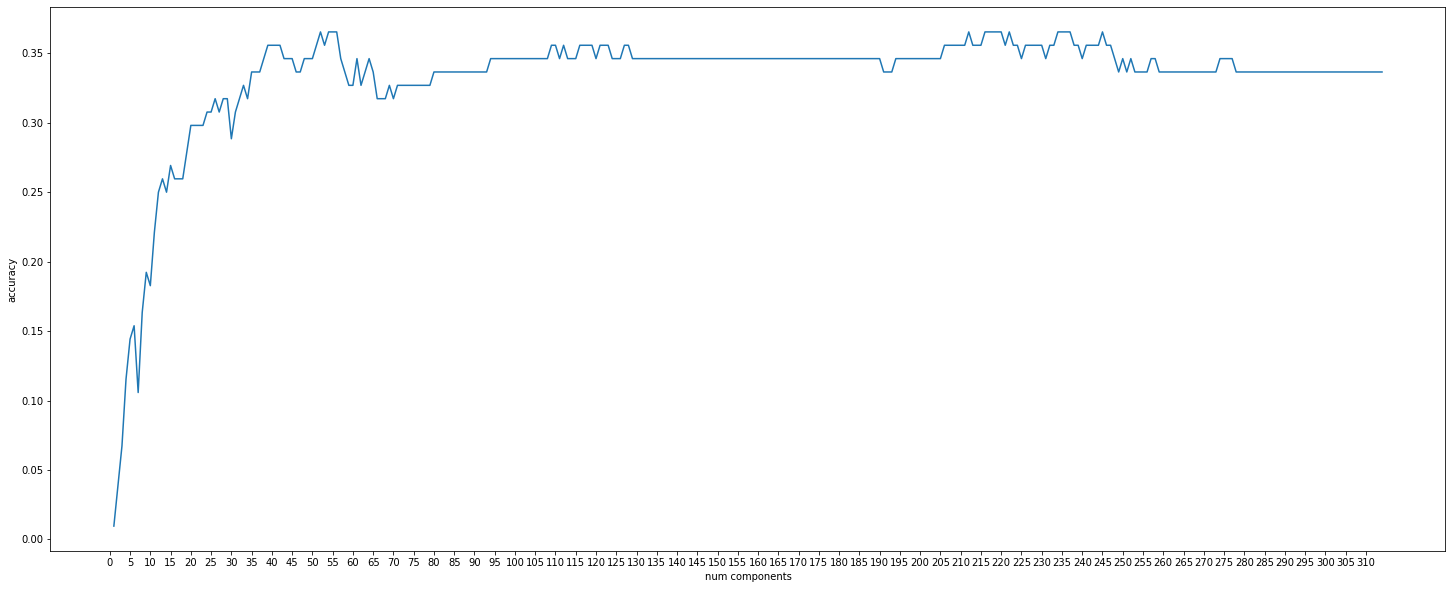

In [ ]:
visualize_results(accuracies, 5, 'accuracy')

In [ ]:
visualize_confusion_mat(eig_vecs_3, X123_train - mean3, X_test - mean3, M, 3 * Yn_train)

  , 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52
 1,  0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
 2,  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0
 3,  0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
 4,  0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
 5,  0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
 6,  0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 

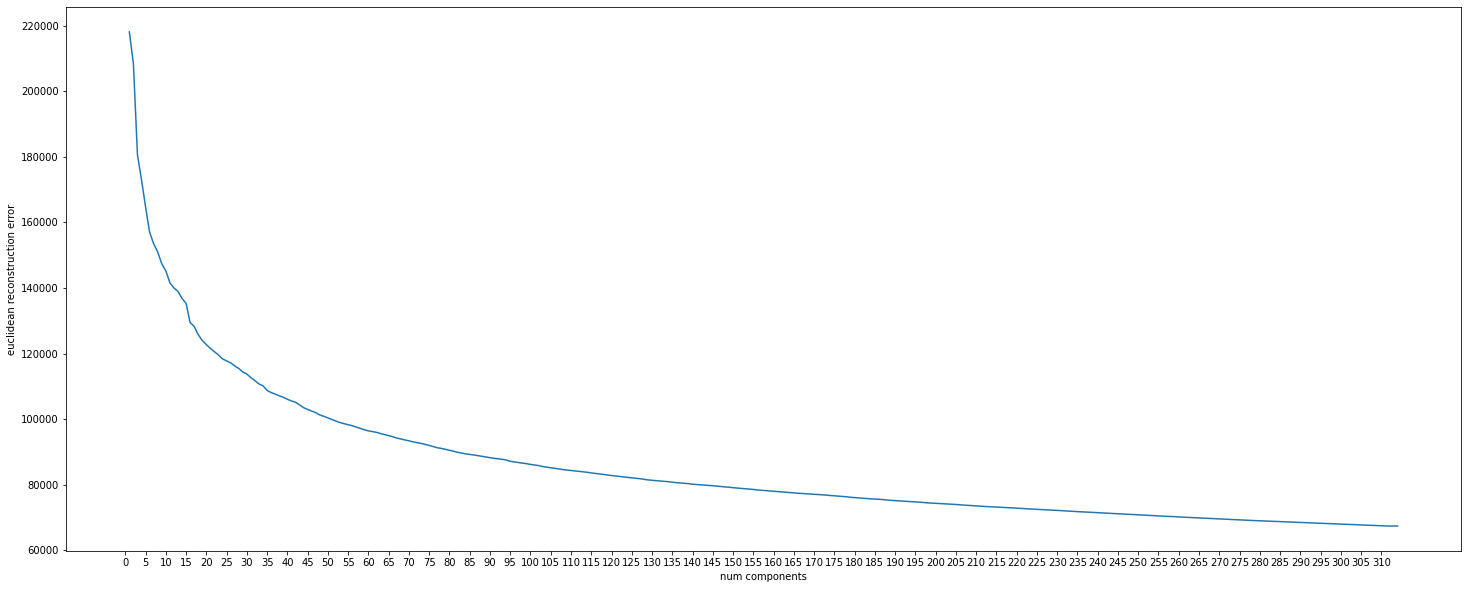

In [ ]:
visualize_results(euc_errors, 5, 'euclidean reconstruction error')

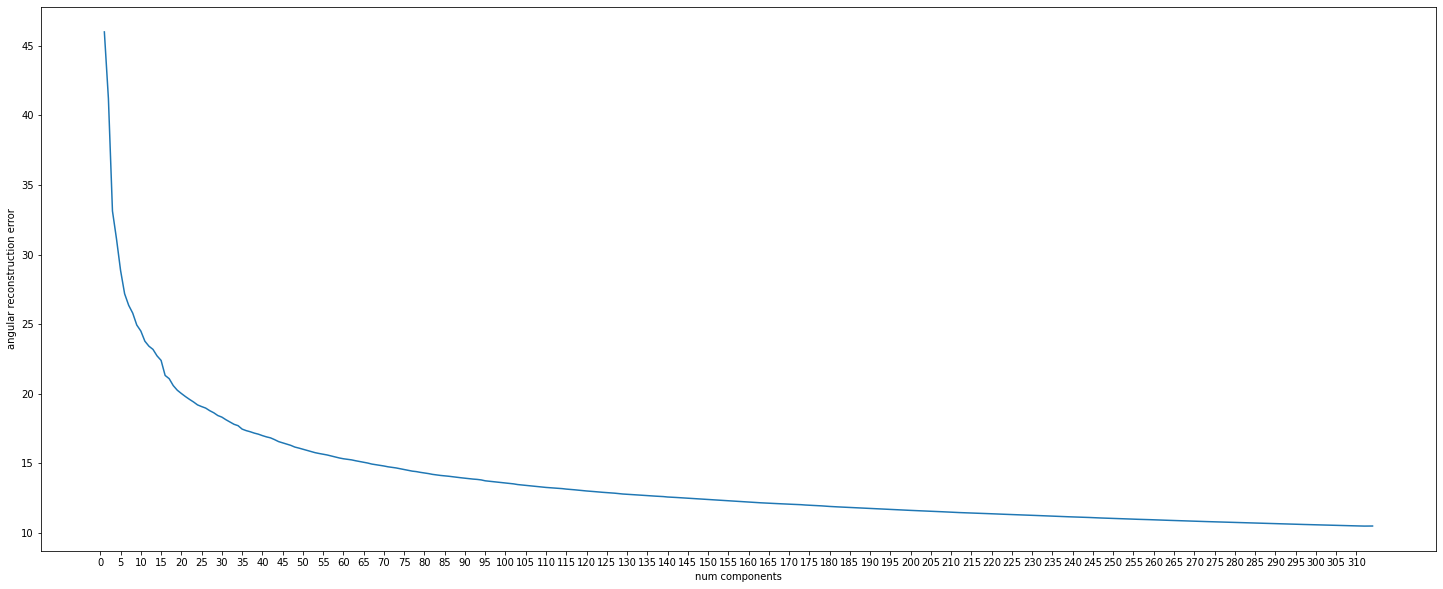

In [ ]:
visualize_results(ang_errors, 5, 'angular reconstruction error')

#### Incremental PCA approach (4 subsets)

Eigen decomposition finished in: 0.0054 secs


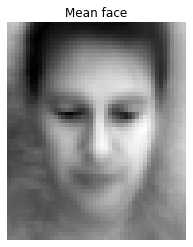

In [ ]:
# train PCA on the 4th subset
mean4, S4, eig_vals_4, eig_vecs_4, _ = train_PCA(X4_train, True)

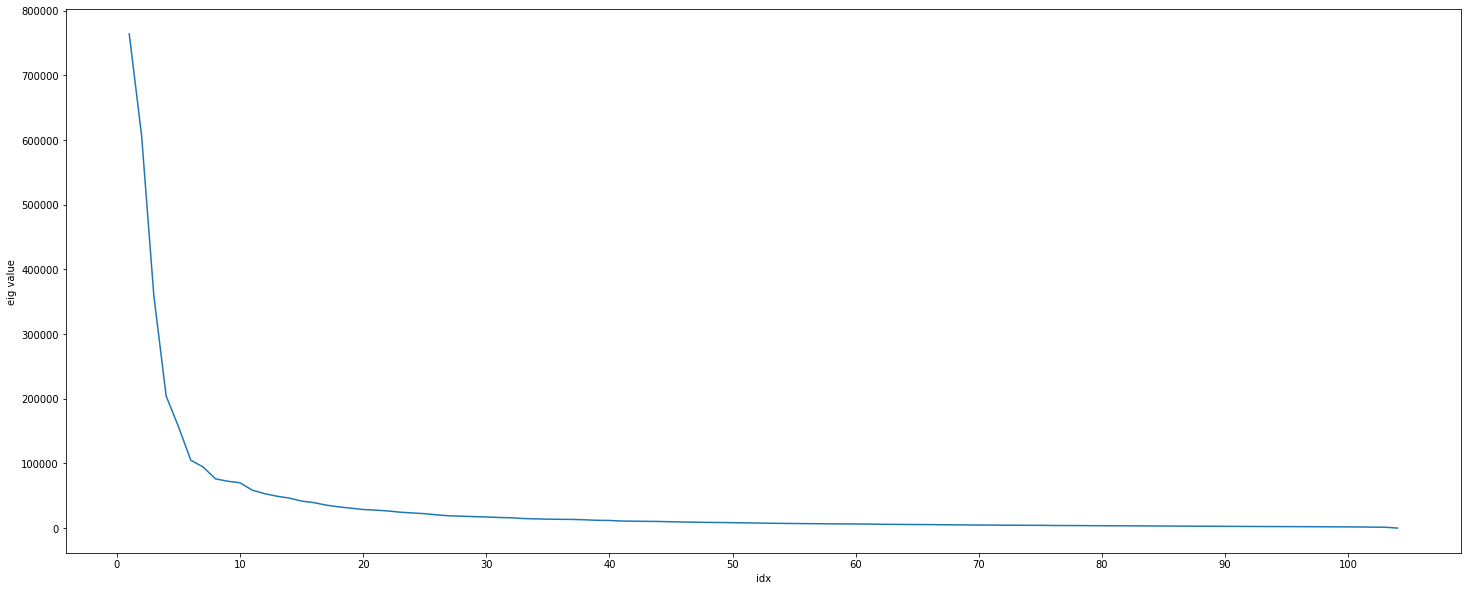

In [ ]:
visualize_results(eig_vals_4, 10, 'eig value', 'idx')

Eigen decomposition finished in: 0.108 secs


  0%|          | 0/419 [00:00<?, ?it/s]

Best accuracy: 0.6731, components: 81
Best euclidean reconstruction error: 56091.1367, components: 416
Best angular reconstruction error: 9.0874, components: 416


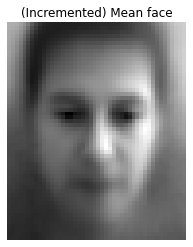

In [ ]:
# get the incremented model
N4 = X4_train.shape[1]
mean4, S4, eig_vals_4, eig_vecs_4, N4 = increment_PCA(mean3, S3, N3, eig_vecs_3, mean4, S4, N4, eig_vecs_4)
X1234_train = torch.cat((X123_train, X4_train), 1)
accuracies, euc_errors, ang_errors, M = test_PCA_all_M(eig_vecs_4, X1234_train - mean4, X_test - mean4, 4 * Yn_train)

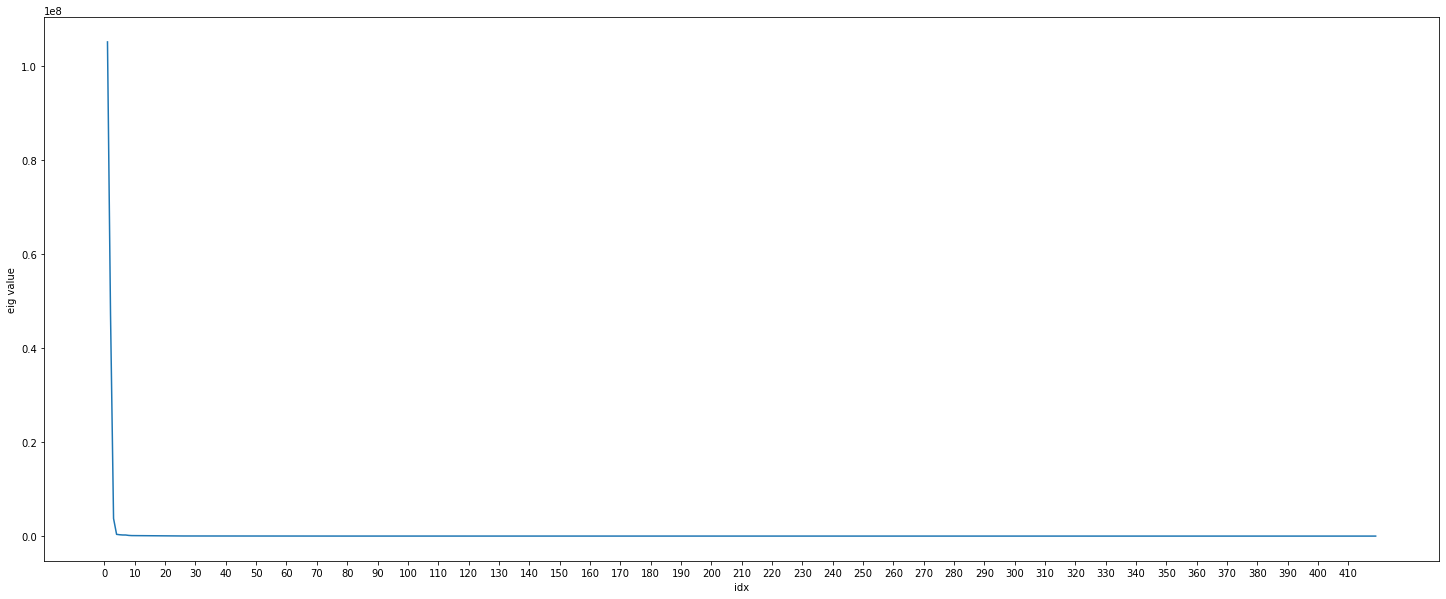

In [ ]:
visualize_results(eig_vals_4, 10, 'eig value', 'idx')

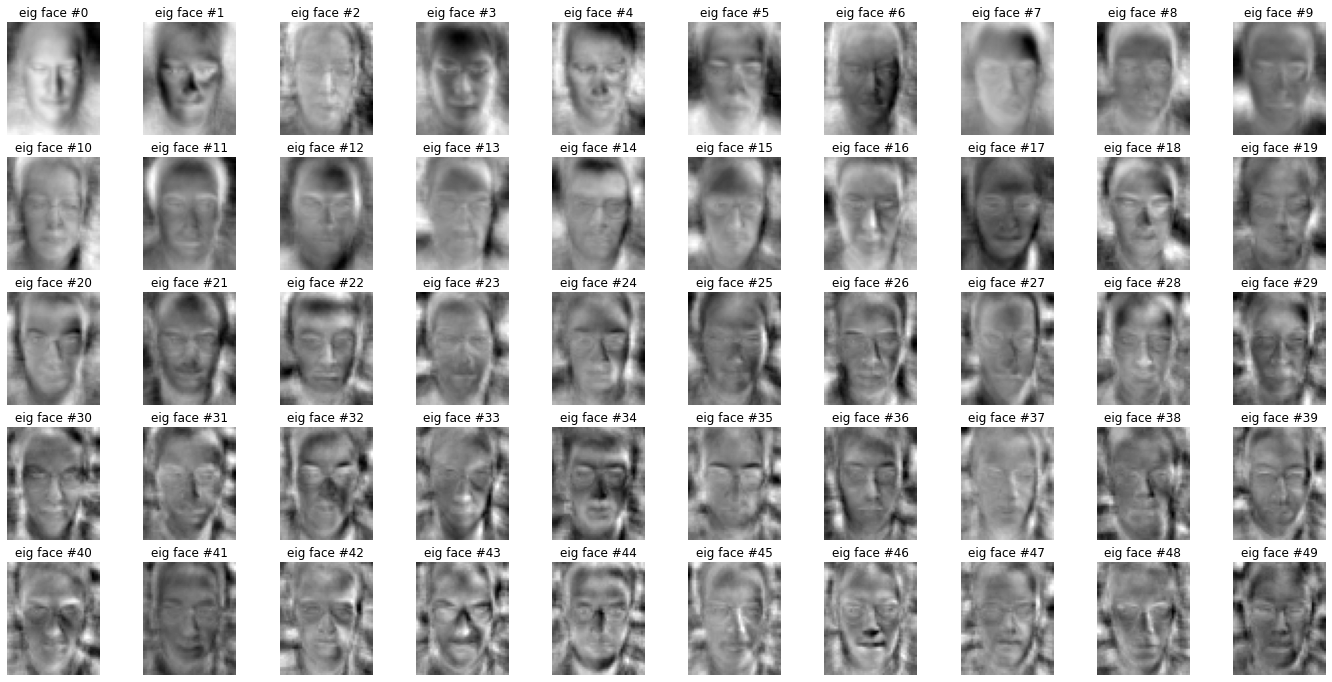

In [ ]:
visualize_eig_faces(eig_vecs_4.T[:50])

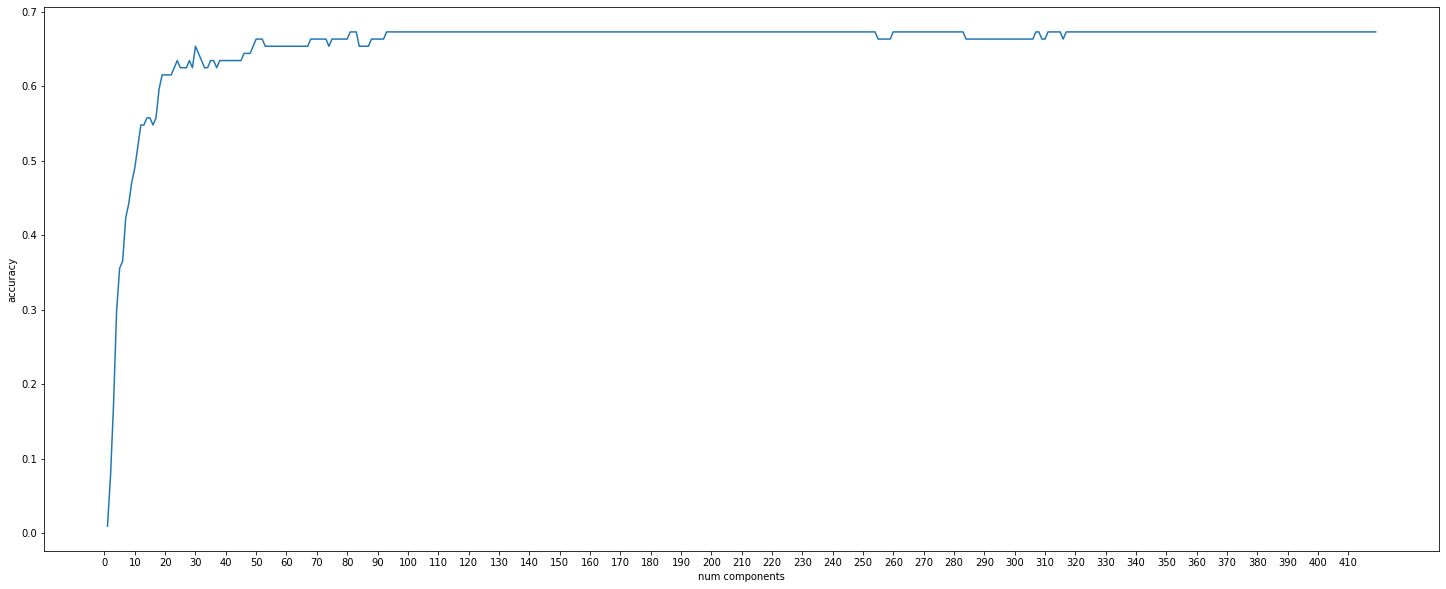

In [ ]:
visualize_results(accuracies, 10, 'accuracy')

In [ ]:
visualize_confusion_mat(eig_vecs_4, X1234_train - mean4, X_test - mean4, M, 4 * Yn_train)

  , 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52
 1,  0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
 2,  0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
 3,  0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
 4,  0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
 5,  0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
 6,  0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 

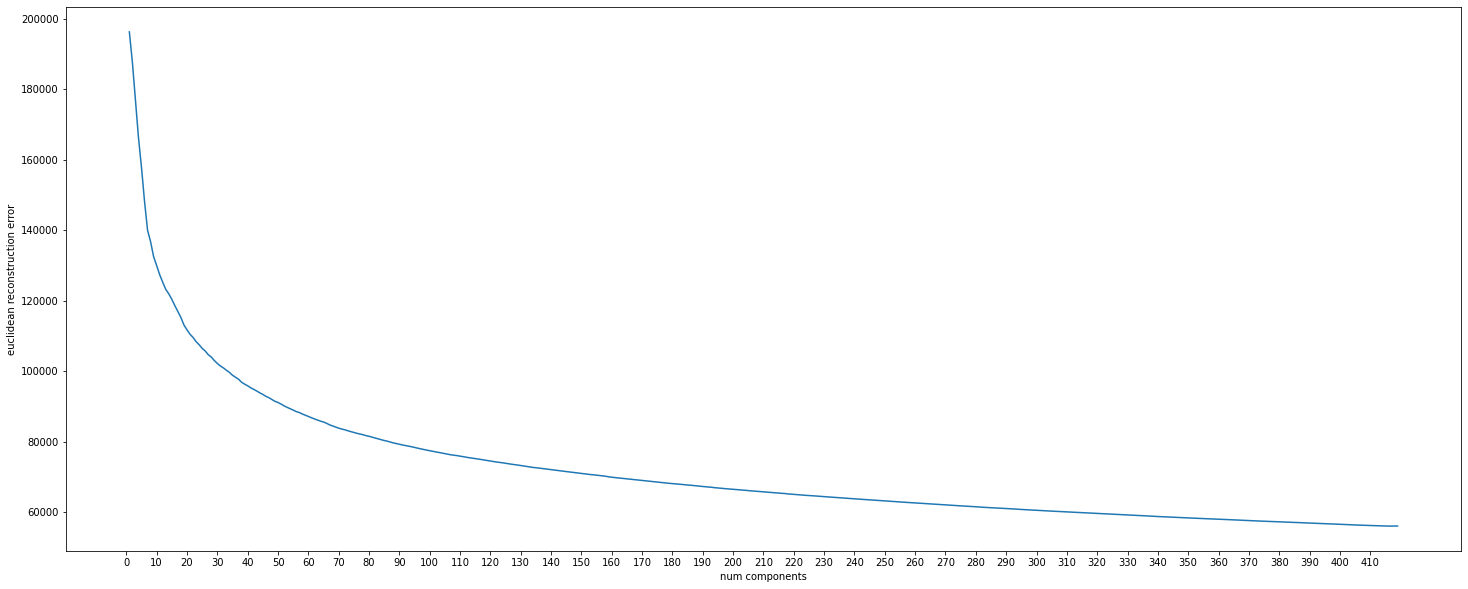

In [ ]:
visualize_results(euc_errors, 10, 'euclidean reconstruction error')

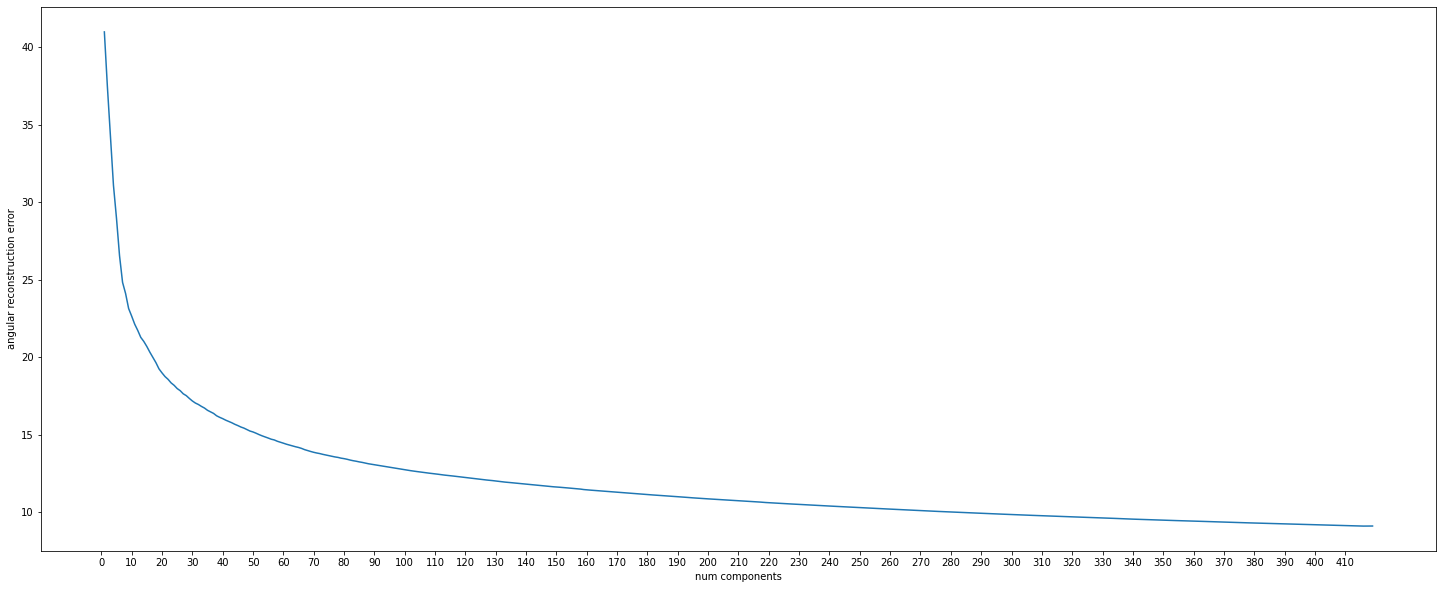

In [ ]:
visualize_results(ang_errors, 10, 'angular reconstruction error')

### Q3

#### Setup

In [ ]:
def get_scatter(X):
  D, _ = X.shape
  SW = torch.zeros((D, D), dtype=torch.float, device=device)
  means = torch.zeros((D, num_classes), dtype=torch.float, device=device)
  for c in range(num_classes):
    Xc = X[:, c*8:(c+1)*8]
    mc = Xc.mean(axis=1, keepdim=True)
    means[:, c] = mc.squeeze()
    A = Xc - mc
    SW += A @ A.T
  mean = X.mean(axis=1, keepdim=True)
  A = means - mean
  SB = 8 * (A @ A.T) # Ni = 8 for all classes
  A = X - mean
  ST = A @ A.T
  rankSB = torch.linalg.matrix_rank(SB, hermitian=True)
  rankSW = torch.linalg.matrix_rank(SW, hermitian=True)
  return SB, rankSB, SW, rankSW, ST

def train_pca_lda(X, print_best: bool):
  SB, rankSB, SW, rankSW, ST = get_scatter(X_train)
  D, N = X_train.shape
  print(f'rank(SB)={rankSB}<=c-1={num_classes-1}, rank(SW)={rankSW}<=N-c={N-num_classes}')
  eig_vals_pca, eig_vecs_pca = eig_dec(ST)
  PCA_Ms = []
  LDA_Ms = []
  ACCs = []
  EUC_ERRs = []
  ANG_ERRs = []
  best_acc = best_euc_err = best_ang_err = None
  for Mpca in notebook.tqdm(range(1, rankSW + 1)):
    Wpca = eig_vecs_pca[:, :Mpca] # D x Mpca
    _, eig_vecs_lda = eig_dec(torch.linalg.solve(Wpca.T @ SW @ Wpca, Wpca.T @ SB @ Wpca), False)
    Wopt = Wpca @ eig_vecs_lda # D x Mpca
    accuracies, euc_errors, ang_errors, _ = test_PCA_all_M(Wopt, X_train, X_test, Y_train, rankSB, False, False) # normalize X_train, X_test?
    for i, (acc, euc_err, ang_err) in enumerate(zip(accuracies, euc_errors, ang_errors)):
      Mlda = i + 1
      PCA_Ms.append(Mpca)
      LDA_Ms.append(Mlda)
      ACCs.append(acc)
      EUC_ERRs.append(euc_err)
      ANG_ERRs.append(ang_err)
      if best_acc == None or acc > best_acc[0]:
        best_acc = (acc, Mpca, Mlda, Wopt[:, :Mlda])
      if best_euc_err == None or euc_err < best_euc_err[0]:
        best_euc_err = (euc_err, Mpca, Mlda)
      if best_ang_err == None or ang_err < best_ang_err[0]:
        best_ang_err = (ang_err, Mpca, Mlda)
  if print_best:
    print(f'Best accuracy: {round(float(best_acc[0]), 4)}, Mpca: {best_acc[1]}, Mlda: {best_acc[2]}')
    print(f'Best euclidean rec. error: {round(float(best_euc_err[0]), 4)}, Mpca: {best_euc_err[1]}, Mlda: {best_euc_err[2]}')
    print(f'Best angular rec. error: {round(float(best_ang_err[0]), 4)}, Mpca: {best_ang_err[1]}, Mlda: {best_ang_err[2]}')
  Wopt = best_acc[3] # (D x Mlda) where Mlda maximizes classification accuracy
  return Wopt, PCA_Ms, LDA_Ms, ACCs, EUC_ERRs, ANG_ERRs

def visualize_pca_lda_results(x, y, z, z_label: str, azim=None):
  fig = plt.figure(figsize=(12, 12))
  ax = plt.axes(projection="3d")
  ax.scatter3D(x, y, z, c=z, cmap='hsv');
  ax.set_xlabel('M-pca')
  ax.set_ylabel('M-lda')
  ax.set_zlabel(z_label)
  if azim != None:
    ax.azim = azim
  plt.show()

#### Testing

In [ ]:
Wopt, PCA_Ms, LDA_Ms, accuracies, euc_errors, ang_errors = train_pca_lda(X_train, True)

rank(SB)=51<=c-1=51, rank(SW)=352<=N-c=364
Eigen decomposition finished in: 9.0936 secs


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Best accuracy: 0.9135, Mpca: 64, Mlda: 19
Best euclidean rec. error: 251834.9531, Mpca: 3, Mlda: 3
Best angular rec. error: 17.9497, Mpca: 3, Mlda: 3


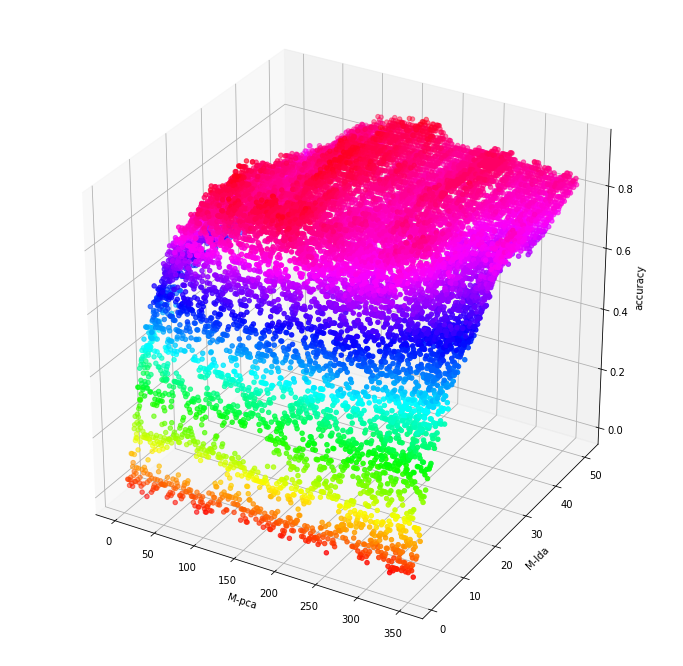

In [ ]:
visualize_pca_lda_results(PCA_Ms, LDA_Ms, accuracies, 'accuracy')

In [ ]:
visualize_confusion_mat(Wopt, X_train, X_test, Wopt.shape[1], Y_train)

  , 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52
 1,  2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
 2,  0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
 3,  0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
 4,  0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
 5,  0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
 6,  0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 

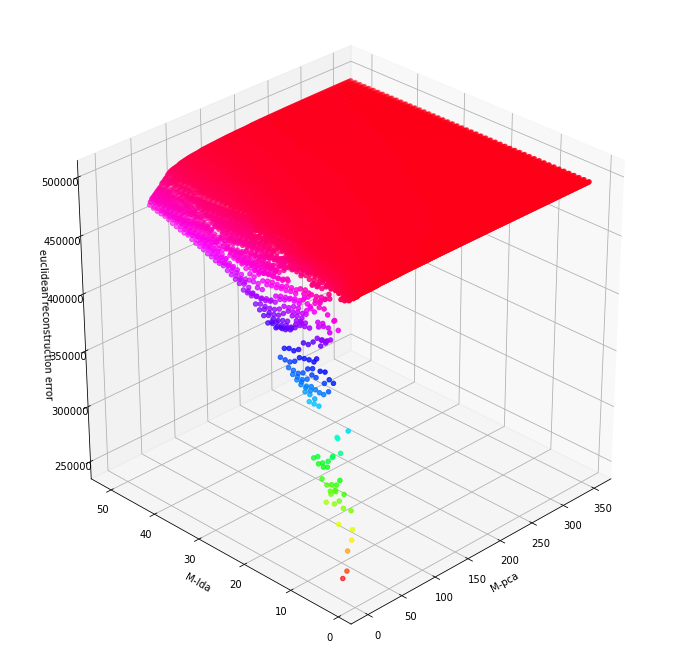

In [ ]:
visualize_pca_lda_results(PCA_Ms, LDA_Ms, euc_errors, 'euclidean reconstruction error', 225)

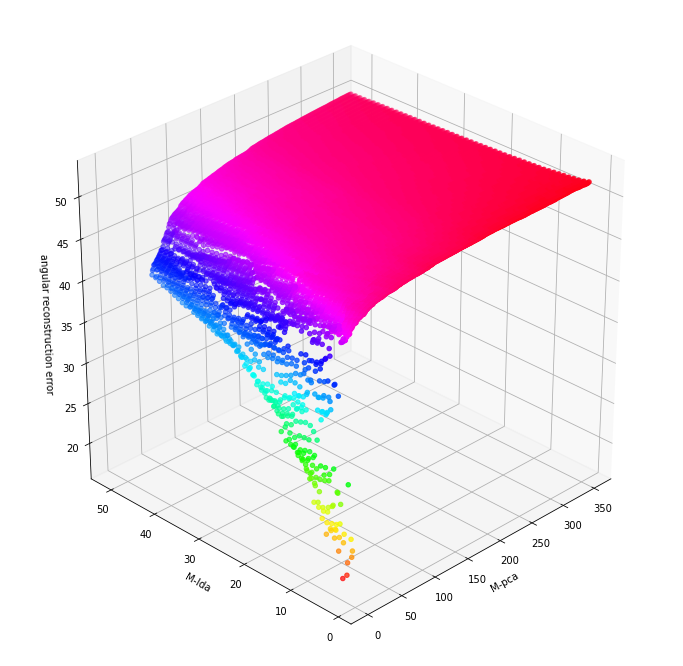

In [ ]:
visualize_pca_lda_results(PCA_Ms, LDA_Ms, ang_errors, 'angular reconstruction error', 225)